# Monopolar beta power estimation methods, validated by externalized beta power

In [1]:

import plotly
import plotly.graph_objs as go

# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
from scipy import stats
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz

import seaborn as sns
import pingouin as pg
from itertools import combinations
from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv
import h5py
import fooof
from fooof.plts.spectra import plot_spectrum

#mne
from pathlib import Path
import mne_bids
from mne_bids import (
    BIDSPath,
    inspect_dataset,
    mark_channels)
import mne
from mne.time_frequency import tfr_morlet 


In [14]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'BetaSenSightLongterm', 'BetaSenSightLongterm')
sys.path.append(project_path)

os.chdir(project_path)

import src.bssu.utils.find_folders as find_folders
importlib.reload(find_folders)

# import PyPerceive

project_path = find_folders.chdir_repository("Py_Perceive")

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)

import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as PyPerceive_find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

# import meet

project_path = find_folders.chdir_repository("meet")

import meet as meet

# import all functions from BetaSenSightLongterm
project_path = find_folders.chdir_repository("BetaSenSightLongterm")

# tfr, processing
import src.bssu.tfr.BSSuPsd as BSSuPsd
import src.bssu.tfr.FastFourierPSD as FFpsd

# bipolar Channel Analysis
import src.bssu.bipolar.power_spectra_plots as power_spectra_plots
import src.bssu.bipolar.PeakFrequencies_PSD as PeakFrequency_psd
import src.bssu.bipolar.BIP_channelGroups as BIP_channelGroups
import src.bssu.bipolar.BIP_perChannelAnalysis as BIP_perChannel


# monopolar Referencing
import src.bssu.monopolar.MonoRef_JLB as MonoRefJLB
import src.bssu.monopolar.GroupMonopolarPSD as groupMonopol
import src.bssu.monopolar.monoRef_weightPsdAverageByCoordinateDistance as MonoRefWeightedCoordinateDistance
import src.bssu.monopolar.externalized_lfp as externalized
import src.bssu.monopolar.monopol_method_comparison as monopol_comparison
import src.bssu.monopolar.bssu_contacts_maximal_beta as bssu_contacts
import src.bssu.monopolar.monoRef_Strelow as detec_strelow

# Ranking Order
import src.bssu.ranking.HighestRankedChannelPSD as highestRank
import src.bssu.ranking.monopolPSDaverage_withinSubject as PSDaverageMonopol
import src.bssu.ranking.BIPchannelGroups_ranks as BIP_ranks
import src.bssu.ranking.Permutation_rankings as Permute_ranks


# Clinical stimulation parameters
import src.bssu.stimulation.activeStimulationContacts as activeStimContacts

# utility functions
import src.bssu.utils.loadResults as loadResults
import src.bssu.utils.find_folders as find_folders
import src.bssu.utils.writeGroupDataframes as writeGroupDF
import src.bssu.utils.load_data_files as load_data
import src.bssu.utils.monopol_comparison_helpers as mono_comp_helpers

# import Classes
from src.bssu.classes import (metadataAnalysis_class, mainAnalysis_class, sessionAnalysis_class, 
                              channelAnalysis_class, featureAnalysis_class, frequencyBand_class)

# import mni coordinates
import src.bssu.mni.load_rotated_coordinates as load_mni


importlib.reload(BSSuPsd)
importlib.reload(MonoRefJLB)
importlib.reload(loadResults)
importlib.reload(highestRank)
importlib.reload(groupMonopol)
importlib.reload(PSDaverageMonopol)
importlib.reload(FFpsd)
importlib.reload(find_folders)
importlib.reload(metadataAnalysis_class)
importlib.reload(mainAnalysis_class)
importlib.reload(sessionAnalysis_class)
importlib.reload(channelAnalysis_class)
importlib.reload(featureAnalysis_class)
importlib.reload(frequencyBand_class)
importlib.reload(PeakFrequency_psd)
importlib.reload(power_spectra_plots)
importlib.reload(BIP_channelGroups)
importlib.reload(BIP_ranks)
importlib.reload(activeStimContacts)
importlib.reload(Permute_ranks)
importlib.reload(BIP_perChannel)
importlib.reload(load_mni)
importlib.reload(writeGroupDF)
importlib.reload(MonoRefWeightedCoordinateDistance)
importlib.reload(load_data)
importlib.reload(externalized)
importlib.reload(monopol_comparison)
importlib.reload(bssu_contacts)
importlib.reload(mono_comp_helpers)
importlib.reload(detec_strelow)

# load if you want to see complete Dataframes
pd.set_option("display.max_rows", None)

Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data


## Load data

In [8]:

externalized_fooof = mono_comp_helpers.load_externalized_fooof_data(fooof_version="v2", reference="bipolar_to_lowermost")

externalized_ssd = mono_comp_helpers.load_externalized_ssd_data(reference="bipolar_to_lowermost")

JLB_directional = mono_comp_helpers.load_JLB_method(fooof_version="v2")
JLB_directional_extern_bssu = mono_comp_helpers.load_JLB_externalized_bssu(fooof_version="v2")

euclidean_directional = mono_comp_helpers.load_euclidean_method(fooof_version="v2")
euclidean_directional_extern_bssu = mono_comp_helpers.load_euclidean_externalized_bssu(fooof_version="v2")

best_bssu_contacts = mono_comp_helpers.load_best_bssu_method(fooof_version="v2")
best_bssu_contacts_extern_bssu = mono_comp_helpers.load_best_externalized_bssu(fooof_version="v2")

detec_strelow_contacts = mono_comp_helpers.load_detec_strelow_beta_ranks(fooof_version="v2", level_first_or_all_directional="level_first")
detec_strelow_contacts_extern_bssu = mono_comp_helpers.load_detec_strelow_beta_ranks_externalized_bssu(fooof_version="v2", level_first_or_all_directional="level_first")

best_clinical_contacts = mono_comp_helpers.load_best_clinical_contacts()



Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/data


In [16]:
detec_strelow_contacts_extern_bssu.head()

,subject_hemisphere,session,contact,weighted_fooof_power_spectrum,estimated_monopolar_beta_psd,beta_rank,level_or_direction,method
0,024_Right,postop,1A,"[2.0324494626649924e-17, 7.508582215315437e-17...",4.860062e-14,2.0,direction,detec_strelow_contacts_externalized_bssu
1,024_Right,postop,1B,"[3.0699827256699266e-19, 1.4406518165873533e-1...",4.864814e-14,1.0,direction,detec_strelow_contacts_externalized_bssu
2,024_Right,postop,1C,"[2.0624418719014295e-17, 7.645147898288007e-17...",2.767511e-14,3.0,direction,detec_strelow_contacts_externalized_bssu
3,024_Left,postop,2A,"[4.0516722862583457e-14, 3.0123861449864404e-1...",7.637759e-15,3.0,direction,detec_strelow_contacts_externalized_bssu
4,024_Left,postop,2B,"[4.041510955172957e-14, 2.9942101908010914e-14...",1.087553e-14,2.0,direction,detec_strelow_contacts_externalized_bssu


In [4]:
JLB_directional.head()

,session,subject_hemisphere,contact,weighted_fooof_power_spectrum,estimated_monopolar_beta_psd,beta_relative_to_max,beta_cluster,method,beta_rank
postop_024_Right_1A,postop,024_Right,1A,"[0.010710618837743447, 0.007945590224266042, 0...",0.367191,1.000000,1,JLB_directional,1.0
postop_024_Right_1B,postop,024_Right,1B,"[0.0008723526839437407, 0.003882530681184279, ...",0.078137,0.212796,3,JLB_directional,3.0
postop_024_Right_1C,postop,024_Right,1C,"[1.0402991074522788e-13, 7.7462502182915e-12, ...",0.114561,0.311993,3,JLB_directional,2.0
postop_024_Right_2A,postop,024_Right,2A,"[0.008355295651314765, 0.007201510277502971, 0...",0.024373,0.066376,3,JLB_directional,4.0
postop_024_Right_2B,postop,024_Right,2B,"[0.0006805175963206551, 0.0035189436925501597,...",0.005749,0.015656,3,JLB_directional,6.0


In [17]:
detec_strelow_contacts.head()

,subject_hemisphere,session,contact,weighted_fooof_power_spectrum,estimated_monopolar_beta_psd,beta_rank,level_or_direction,method
0,024_Right,postop,1A,"[0.0008051447837384129, 0.0008263686397425934,...",0.020152,2.0,direction,detec_strelow_contacts
1,024_Right,postop,1B,"[0.0007738230873533977, 0.0007442117326068188,...",0.020229,1.0,direction,detec_strelow_contacts
2,024_Right,postop,1C,"[3.1363505930098215e-05, 8.232250501156817e-05...",0.012148,3.0,direction,detec_strelow_contacts
3,024_Left,postop,2A,"[0.006400250819270951, 0.004747475745568836, 0...",0.003686,3.0,direction,detec_strelow_contacts
4,024_Left,postop,2B,"[4.372574815538162e-08, 1.0408669811848649e-07...",0.005074,2.0,direction,detec_strelow_contacts


Load externalized fooofed beta power
- 2 min
- resampled sfreq = 250 Hz
- notch-filtered 50 Hz
- artefact-free
- FOOOFed

In [20]:
externalized_fooof.subject_hemisphere.unique()
# missing: 048_Right, 052_Right, 

array(['024_Right', '024_Left', '025_Right', '025_Left', '028_Right',
       '028_Left', '029_Right', '029_Left', '030_Right', '030_Left',
       '032_Right', '032_Left', '047_Right', '047_Left', '048_Left',
       '049_Right', '049_Left', '052_Left', '056_Right', '056_Left',
       '059_Right', '059_Left', '061_Right', '061_Left', '064_Right',
       '064_Left', '067_Right', '067_Left', '069_Right', '069_Left',
       '071_Right', '071_Left', '072_Right', '072_Left', '075_Right',
       '075_Left', '077_Right', '077_Left', '079_Right', '079_Left',
       '080_Right', '080_Left'], dtype=object)

In [24]:
externalized_ssd.head()

,BIDS_id,subject,hemisphere,subject_hemisphere,contact,ssd_pattern,ssd_eigvals,beta_rank,beta_relative_to_max,beta_cluster,method,session,estimated_monopolar_beta_psd
0,noBIDS24,024,Right,024_Right,1A,1.000000,0.862970,1.0,1.000000,1,externalized_ssd,postop,1.000000
1,noBIDS24,024,Right,024_Right,1B,0.200086,0.796248,6.0,0.200086,3,externalized_ssd,postop,0.200086
2,noBIDS24,024,Right,024_Right,1C,0.664875,0.776448,2.0,0.664875,2,externalized_ssd,postop,0.664875
3,noBIDS24,024,Right,024_Right,2A,0.478567,0.690844,4.0,0.478567,2,externalized_ssd,postop,0.478567
4,noBIDS24,024,Right,024_Right,2B,0.381384,0.639306,5.0,0.381384,3,externalized_ssd,postop,0.381384


: 

Load beta ranks of Euclidean method

In [7]:
monopolar_fooof_euclidean_segmental = loadResults.load_fooof_monopolar_weighted_psd(
    fooof_spectrum = "periodic_spectrum",
    fooof_version = "v2",
    segmental = "yes",
    similarity_calculation = "inverse_distance"
)

monopolar_fooof_euclidean_segmental = pd.concat([
    monopolar_fooof_euclidean_segmental["postop_monopolar_Dataframe"],
    monopolar_fooof_euclidean_segmental["fu3m_monopolar_Dataframe"],
    monopolar_fooof_euclidean_segmental["fu12m_monopolar_Dataframe"],
    monopolar_fooof_euclidean_segmental["fu18or24m_monopolar_Dataframe"],])

In [9]:
df = monopolar_fooof_euclidean_segmental

Load beta ranks of JLB method

In [8]:
monopolar_fooof_JLB = loadResults.load_pickle_group_result(
    filename="MonoRef_JLB_fooof_beta",
    fooof_version="v2"
)


In [9]:
monopolar_fooof_JLB.head()

,session,subject_hemisphere,contact,estimated_monopolar_beta_psd,rank,beta_relative_to_max,beta_cluster
postop_024_Right_1A,postop,024_Right,1A,0.043229,1.0,1.0,1
postop_024_Right_1B,postop,024_Right,1B,0.00833,3.0,0.192705,3
postop_024_Right_1C,postop,024_Right,1C,0.010651,2.0,0.246379,3
postop_024_Right_2A,postop,024_Right,2A,0.002801,4.0,0.06479,3
postop_024_Right_2B,postop,024_Right,2B,0.00054,6.0,0.012485,3


In [11]:
monopolar_fooof_euclidean_segmental = mono_comp_helpers.load_euclidean_method(fooof_version="v2")
monopolar_fooof_JLB = mono_comp_helpers.load_JLB_method(fooof_version="v2")

In [13]:
monopolar_fooof_euclidean_segmental.head()

,coord_z,coord_xy,session,subject_hemisphere,estimated_monopolar_beta_psd,contact,beta_relative_to_max,beta_cluster,method,beta_rank
1A,2.0+0.0j,0.650000+0.000000j,postop,024_Right,0.137599,1A,1.000000,1,euclidean_directional,1.0
1B,2.0+0.0j,-0.325000+0.562917j,postop,024_Right,0.132774,1B,0.964935,1,euclidean_directional,2.0
1C,2.0+0.0j,-0.325000-0.562917j,postop,024_Right,0.117662,1C,0.855104,1,euclidean_directional,3.0
2A,4.0+0.0j,0.650000+0.000000j,postop,024_Right,0.076946,2A,0.559200,2,euclidean_directional,4.0
2B,4.0+0.0j,-0.325000+0.562917j,postop,024_Right,0.074043,2B,0.538109,2,euclidean_directional,5.0


In [15]:
monopolar_fooof_JLB.head()

,session,subject_hemisphere,contact,estimated_monopolar_beta_psd,beta_relative_to_max,beta_cluster,method,beta_rank
postop_024_Right_1A,postop,024_Right,1A,0.043229,1.0,1,JLB_directional,1.0
postop_024_Right_1B,postop,024_Right,1B,0.00833,0.192705,3,JLB_directional,3.0
postop_024_Right_1C,postop,024_Right,1C,0.010651,0.246379,3,JLB_directional,2.0
postop_024_Right_2A,postop,024_Right,2A,0.002801,0.06479,3,JLB_directional,4.0
postop_024_Right_2B,postop,024_Right,2B,0.00054,0.012485,3,JLB_directional,6.0


In [16]:

method_1_session = monopolar_fooof_euclidean_segmental.loc[monopolar_fooof_euclidean_segmental.session == "fu3m"]
method_2_session = monopolar_fooof_JLB.loc[monopolar_fooof_JLB.session == "fu3m"]

method_1 = "euclidean_directional"
method_2 = "JLB_directional"

percept_methods_corr = mono_comp_helpers.correlation_tests_percept_methods(
    method_1=method_1, method_2=method_2, method_1_df=method_1_session, method_2_df=method_2_session, ses="fu3m"
        
)

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [18]:
percept_methods_corr.head()

,method_1,method_2,session,subject_hemisphere,estimated_beta_spearman_r,estimated_beta_spearman_pval,normalized_beta_pearson_r,normalized_beta_pearson_pval,cluster_beta_spearman_r,cluster_beta_spearman_pval,contact_rank_1_method_1,contact_rank_1_method_2,contacts_rank_1_2_method_1,contacts_rank_1_2_method_2,compare_rank_1_contact,compare_rank_1_and_2_contacts,both_contacts_matching
0,euclidean_directional,JLB_directional,fu3m,017_Left,0.485714,0.328723,0.667798,0.147206,NaN,NaN,2A,2A,"[2A, 2C]","[2A, 1A]",same,at_least_one_contact_match,no
1,euclidean_directional,JLB_directional,fu3m,017_Right,-0.142857,0.787172,-0.370202,0.470065,NaN,NaN,2A,1A,"[2A, 2C]","[1A, 2A]",different,at_least_one_contact_match,no
2,euclidean_directional,JLB_directional,fu3m,019_Left,-0.142857,0.787172,-0.301251,0.561793,-0.692820,0.127046,1A,2A,"[1A, 1C]","[2A, 2B]",different,no_contacts_match,no
3,euclidean_directional,JLB_directional,fu3m,019_Right,0.942857,0.004805,0.948804,0.003864,NaN,NaN,1A,1A,"[1A, 1C]","[1A, 1C]",same,at_least_one_contact_match,yes
4,euclidean_directional,JLB_directional,fu3m,021_Left,0.942857,0.004805,0.872443,0.023368,0.948683,0.003883,1C,1C,"[1C, 1B]","[1C, 1A]",same,at_least_one_contact_match,no


Load the contact pair with maximal beta power (Binder et al. 2023)

In [30]:
best_bssu_directional_contacts = bssu_contacts.select_directional_contact_pair_from_bssu(fooof_version="v2")

best_2_contacts_from_directional_bssu_v2.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/results


In [31]:
best_bssu_contacts = loadResults.load_pickle_group_result(
    filename="best_2_contacts_from_directional_bssu",
    fooof_version="v2"
)

In [32]:
best_bssu_contacts.head()

,session,subject_hemisphere,selected_2_contacts
postop_024_Right,postop,024_Right,"[1A, 1B]"
postop_024_Left,postop,024_Left,"[1A, 2A]"
postop_025_Right,postop,025_Right,"[1A, 2A]"
postop_025_Left,postop,025_Left,"[1A, 2A]"
postop_028_Right,postop,028_Right,"[1A, 2A]"


In [2]:
# load Excel file with best clinical stimulation parameters
best_clinical_stimulation = loadResults.load_BestClinicalStimulation_excel()
best_clinical_contacts = best_clinical_stimulation["BestContacts_one_longterm"]  # or BestClinicalContacts

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/data


In [10]:
best_clinical_contacts.loc[best_clinical_contacts.session == "fu12m"]

,subject_hemisphere,session,CathodalContact,currentPolarity,InactiveContacts
2,017_Right,fu12m,2A_2B_2C_3,25_25_25_25,0_1A_1B_1C
3,017_Left,fu12m,2A_2B_2C_3,25_25_25_25,0_1A_1B_1C
8,019_Right,fu12m,0,100,1A_1B_1C_2A_2B_2C_3
9,019_Left,fu12m,1A_1B_1C,33_33_33,0_2A_2B_2C_3
14,021_Right,fu12m,0_1B,50_50,1A_1C_2A_2B_2C_3
15,021_Left,fu12m,0_1B,50_50,1A_1C_2A_2B_2C_3
20,023_Right,fu12m,2A_2B_2C,33_33_33,0_1A_1B_1C_3
21,023_Left,fu12m,2A_2B_2C,33_33_33,0_1A_1B_1C_3
26,024_Right,fu12m,1A_1B_1C,33_33_33,0_2A_2B_2C_3
27,024_Left,fu12m,1A_1B_1C,33_33_33,0_2A_2B_2C_3


## Correlation between Percept methods

In [2]:
spearman_between_methods = monopol_comparison.correlation_monopol_fooof_beta_methods(
    method_1="euclidean_directional",
    method_2="detec_strelow_contacts",
    fooof_version="v2"
)

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [5]:
spearman_between_methods["correlation"]

,session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant
0,postop,euclidean_directional,detec_strelow_contacts,38,estimated_beta_spearman,0.748872,0.771429,0.213221,18,0.473684
1,postop,euclidean_directional,detec_strelow_contacts,38,normalized_beta_pearson,0.861298,0.919626,0.145634,28,0.736842
2,postop,euclidean_directional,detec_strelow_contacts,38,cluster_beta_spearman,0.810792,0.948683,0.239539,14,0.368421
3,fu3m,euclidean_directional,detec_strelow_contacts,42,estimated_beta_spearman,0.723810,0.857143,0.343970,28,0.666667
4,fu3m,euclidean_directional,detec_strelow_contacts,42,normalized_beta_pearson,0.807960,0.936333,0.334348,31,0.738095
5,fu3m,euclidean_directional,detec_strelow_contacts,42,cluster_beta_spearman,0.825937,0.948683,0.187514,10,0.238095
6,fu12m,euclidean_directional,detec_strelow_contacts,38,estimated_beta_spearman,0.804511,0.885714,0.261741,26,0.684211
7,fu12m,euclidean_directional,detec_strelow_contacts,38,normalized_beta_pearson,0.868970,0.955461,0.236010,33,0.868421
8,fu12m,euclidean_directional,detec_strelow_contacts,38,cluster_beta_spearman,0.786026,0.948683,0.200721,9,0.236842
9,fu18or24m,euclidean_directional,detec_strelow_contacts,18,estimated_beta_spearman,0.720635,0.771429,0.253333,8,0.444444


In [6]:
spearman_between_methods["rank"]

,session,method_1,method_2,sample_size,same_rank_1,percentage_same_rank_1,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,both_contacts_matching,percentage_both_contacts_matching
0,postop,euclidean_directional,detec_strelow_contacts,38,22,0.578947,38,1.000000,20,0.526316
1,fu3m,euclidean_directional,detec_strelow_contacts,42,24,0.571429,40,0.952381,27,0.642857
2,fu12m,euclidean_directional,detec_strelow_contacts,38,28,0.736842,37,0.973684,24,0.631579
3,fu18or24m,euclidean_directional,detec_strelow_contacts,18,12,0.666667,17,0.944444,8,0.444444


In [7]:
spearman_between_methods["single_stn_results"].head()

,method_1,method_2,session,subject_hemisphere,estimated_beta_spearman_r,estimated_beta_spearman_pval,normalized_beta_pearson_r,normalized_beta_pearson_pval,cluster_beta_spearman_r,cluster_beta_spearman_pval,contact_rank_1_method_1,contact_rank_1_method_2,contacts_rank_1_2_method_1,contacts_rank_1_2_method_2,compare_rank_1_contact,compare_rank_1_and_2_contacts,both_contacts_matching,significant_estimated_beta_spearman,significant_normalized_beta_pearson,significant_cluster_beta_spearman
0,euclidean_directional,detec_strelow_contacts,postop,024_Left,0.714286,0.110787,0.951884,0.003417,0.948683,0.003883,1A,1A,"[1A, 1B]","[1A, 1C]",same,at_least_one_contact_match,no,no,yes,yes
1,euclidean_directional,detec_strelow_contacts,postop,024_Right,0.771429,0.072397,0.982637,0.000450,0.948683,0.003883,1A,1B,"[1A, 1B]","[1B, 1A]",different,at_least_one_contact_match,yes,no,yes,yes
2,euclidean_directional,detec_strelow_contacts,postop,025_Left,0.942857,0.004805,0.985039,0.000334,0.948683,0.003883,1A,1A,"[1A, 1C]","[1A, 1B]",same,at_least_one_contact_match,no,yes,yes,yes
3,euclidean_directional,detec_strelow_contacts,postop,025_Right,0.942857,0.004805,0.964583,0.001859,0.948683,0.003883,1A,1A,"[1A, 1C]","[1A, 1C]",same,at_least_one_contact_match,yes,yes,yes,yes
4,euclidean_directional,detec_strelow_contacts,postop,028_Left,0.600000,0.208000,0.836779,0.037787,0.316228,0.541470,2A,2B,"[2A, 2B]","[2B, 2A]",different,at_least_one_contact_match,yes,no,yes,no


In [9]:
# 3 versions of correlations: "estimated_beta_spearman", "normalized_beta_pearson", "cluster_beta_spearman"

spearman_between_methods["correlation"].loc[spearman_between_methods["correlation"].correlation == "normalized_beta_pearson"]

,session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant
1,postop,euclidean_directional,detec_strelow_contacts,38,normalized_beta_pearson,0.861298,0.919626,0.145634,28,0.736842
4,fu3m,euclidean_directional,detec_strelow_contacts,42,normalized_beta_pearson,0.807960,0.936333,0.334348,31,0.738095
7,fu12m,euclidean_directional,detec_strelow_contacts,38,normalized_beta_pearson,0.868970,0.955461,0.236010,33,0.868421
10,fu18or24m,euclidean_directional,detec_strelow_contacts,18,normalized_beta_pearson,0.806948,0.925944,0.247362,12,0.666667


## rank comparison between Percept methods

In [34]:
rank_comparison = monopol_comparison.rank_comparison_percept_methods(method_1="euclidean_directional_externalized_bssu", method_2="JLB_directional_externalized_bssu", fooof_version="v2", bssu_version="externalized")

no rank 1 contact in 067_Left JLB_directional_externalized_bssu
no rank 1 contact in 069_Right JLB_directional_externalized_bssu
no rank 1 contact in 072_Left JLB_directional_externalized_bssu
no rank 1 contact in 075_Right JLB_directional_externalized_bssu
no rank 1 contact in 079_Left JLB_directional_externalized_bssu
file:  fooof_monopol_best_contacts_per_stn_euclidean_directional_externalized_bssu_JLB_directional_externalized_bssu__externalized_bssuv2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [35]:
rank_comparison["rank"]

,method_1,method_2,session,sample_size,both_contacts_matching,percentage_both_contacts_matching,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2
0,euclidean_directional_externalized_bssu,JLB_directional_externalized_bssu,postop,28,7,0.25,16,0.571429


In [58]:
rank_comparison[1].head()

,method_1,method_2,session,subject_hemisphere,contact_rank_1_method_1,contact_rank_2_method_1,rank_1_and_2_method_1,contact_rank_1_method_2,contact_rank_2_method_2,rank_1_and_2_method_2,both_contacts_matching,at_least_1_contact_matching
0,best_bssu_contacts,detec_strelow_contacts,postop,024_Left,none,none,"[1A, 2A]",2C,2B,"[2C, 2B]",no,no_contacts_match
1,best_bssu_contacts,detec_strelow_contacts,postop,024_Right,none,none,"[1A, 1B]",1B,1A,"[1B, 1A]",yes,at_least_one_contact_match
2,best_bssu_contacts,detec_strelow_contacts,postop,025_Left,none,none,"[1A, 2A]",1A,1B,"[1A, 1B]",no,at_least_one_contact_match
3,best_bssu_contacts,detec_strelow_contacts,postop,025_Right,none,none,"[1A, 2A]",1A,1C,"[1A, 1C]",no,at_least_one_contact_match
4,best_bssu_contacts,detec_strelow_contacts,postop,028_Left,none,none,"[1A, 2A]",2B,2A,"[2B, 2A]",no,at_least_one_contact_match


### Compare best BSSU directional contact pair to methods

In [32]:
best_bssu_vs_methods = monopol_comparison.compare_method_to_best_bssu_contact_pair(fooof_version="v2")

file:  fooof_monopol_best_contacts_per_stn_JLB_directional_best_bssu_contacts_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_JLB_directional_best_bssu_contacts_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_best_contacts_per_stn_euclidean_directional_best_bssu_contacts_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_euclidean_directional_best_bssu_contacts_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_best_contacts_per_stn_detec_strelow_contacts_best_bssu_contacts_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_bet

In [33]:
best_bssu_vs_methods[0]

,method_1,method_2,session,sample_size,both_contacts_matching,percentage_both_contacts_matching,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2
0,JLB_directional,best_bssu_contacts,postop,38,16,0.421053,36,0.947368
0,JLB_directional,best_bssu_contacts,fu3m,42,11,0.261905,40,0.952381
0,JLB_directional,best_bssu_contacts,fu12m,38,8,0.210526,35,0.921053
0,JLB_directional,best_bssu_contacts,fu18or24m,18,4,0.222222,18,1.000000
0,euclidean_directional,best_bssu_contacts,postop,76,26,0.342105,71,0.934211
0,euclidean_directional,best_bssu_contacts,fu3m,84,26,0.309524,82,0.976190
0,euclidean_directional,best_bssu_contacts,fu12m,76,18,0.236842,70,0.921053
0,euclidean_directional,best_bssu_contacts,fu18or24m,36,9,0.250000,36,1.000000
0,detec_strelow_contacts,best_bssu_contacts,postop,114,31,0.271930,101,0.885965
0,detec_strelow_contacts,best_bssu_contacts,fu3m,126,34,0.269841,115,0.912698


## Comparison of methods to externalized beta 

Watch out!! data only for 5 directional leads, because a directional contact is used as common reference!
- sub-052: contact 2C Right
- sub-048: contact 2C Right

FOOOF

In [11]:
fooof_externalized_vs_JLB = monopol_comparison.percept_vs_externalized(method="JLB_directional_externalized_bssu", percept_session="postop", strelow_level_first="level_first", externalized_version="externalized_fooof", fooof_version="v2", reference="bipolar_to_lowermost", bssu_version="externalized")

Sub-067_Left has NaN values in the estimated beta average.
Sub-069_Right has NaN values in the estimated beta average.
Sub-072_Left has no rank 2 contact in the recording JLB_directional_externalized_bssu.
Sub-075_Right has NaN values in the estimated beta average.
Sub-079_Left has NaN values in the estimated beta average.
file:  fooof_monopol_beta_correlations_per_stn_JLB_directional_externalized_bssu_externalized_fooof_bipolar_to_lowermost_v2_postop_externalized_bssu.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [45]:
fooof_externalized_vs_JLB[0]

,method_1,method_2,session,subject_hemisphere,estimated_beta_spearman_r,estimated_beta_spearman_pval,normalized_beta_pearson_r,normalized_beta_pearson_pval,cluster_beta_spearman_r,cluster_beta_spearman_pval,contact_rank_1_method_1,contact_rank_1_method_2,contacts_rank_1_2_method_1,contacts_rank_1_2_method_2,compare_rank_1_contact,compare_rank_1_and_2_contacts,both_contacts_matching,significant_estimated_beta_spearman,significant_normalized_beta_pearson,significant_cluster_beta_spearman
0,detec_strelow_contacts,externalized_fooof,postop,024_Left,-0.771429,0.072397,-0.741634,0.091506,-0.900000,0.014500,1A,2B,"[1A, 1B]","[2B, 2A]",different,no_contacts_match,no,no,no,yes
1,detec_strelow_contacts,externalized_fooof,postop,024_Right,-0.028571,0.957155,-0.217698,0.678611,-0.632456,0.177808,2A,1A,"[2A, 1B]","[1A, 2A]",different,at_least_one_contact_match,no,no,no,no
2,detec_strelow_contacts,externalized_fooof,postop,025_Left,-0.200000,0.704000,0.477614,0.338055,0.565685,0.241982,1C,1A,"[1C, 1A]","[1A, 2B]",different,at_least_one_contact_match,no,no,no,no
3,detec_strelow_contacts,externalized_fooof,postop,025_Right,0.542857,0.265703,0.737338,0.094426,0.500000,0.312500,1A,1A,"[1A, 2A]","[1A, 1C]",same,at_least_one_contact_match,no,no,no,no
4,detec_strelow_contacts,externalized_fooof,postop,029_Left,-0.542857,0.265703,-0.334351,0.517162,-0.447214,0.373901,1A,2A,"[1A, 1B]","[2A, 2C]",different,no_contacts_match,no,no,no,no
5,detec_strelow_contacts,externalized_fooof,postop,029_Right,0.085714,0.871743,0.141572,0.789061,-0.447214,0.373901,2A,2B,"[2A, 2C]","[2B, 2A]",different,at_least_one_contact_match,no,no,no,no
6,detec_strelow_contacts,externalized_fooof,postop,030_Left,0.828571,0.041563,0.932814,0.006619,0.900000,0.014500,2B,2B,"[2B, 2C]","[2B, 2C]",same,at_least_one_contact_match,yes,yes,yes,yes
7,detec_strelow_contacts,externalized_fooof,postop,030_Right,-0.542857,0.265703,-0.537341,0.271563,-0.433013,0.391076,2C,1C,"[2C, 2B]","[1C, 1B]",different,no_contacts_match,no,no,no,no
8,detec_strelow_contacts,externalized_fooof,postop,032_Left,0.724714,0.103243,0.625341,0.184259,0.489898,0.323941,2A,2C,"[2A, 2C]","[2C, 2A]",different,at_least_one_contact_match,yes,no,no,no
9,detec_strelow_contacts,externalized_fooof,postop,032_Right,-0.085714,0.871743,-0.058252,0.912720,0.447214,0.373901,2C,1A,"[2C, 2A]","[1A, 1B]",different,no_contacts_match,no,no,no,no


In [46]:
fooof_externalized_vs_JLB[1]

,session,method_1,method_2,sample_size,same_rank_1,percentage_same_rank_1,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,both_contacts_matching,percentage_both_contacts_matching
0,postop,detec_strelow_contacts,externalized_fooof,14,3,0.214286,7,0.5,2,0.142857


In [47]:
fooof_externalized_vs_JLB[2]

,session,percept_session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant
0,postop,fu3m,detec_strelow_contacts,externalized_fooof,14,estimated_beta_spearman,-0.097214,-0.142857,0.585456,2,0.142857
1,postop,fu3m,detec_strelow_contacts,externalized_fooof,14,normalized_beta_pearson,-0.029205,-0.137975,0.634685,4,0.285714
2,postop,fu3m,detec_strelow_contacts,externalized_fooof,14,cluster_beta_spearman,-0.035494,-0.433013,0.587090,2,0.142857


In [92]:
fooof_externalized_vs_JLB[1]

,session,percept_session,method_1,method_2,sample_size,same_rank_1,percentage_same_rank_1,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,both_contacts_matching,percentage_both_contacts_matching
0,postop,postop,JLB_directional,externalized_fooof,22,6,0.272727,17,0.772727,5,0.227273


In [99]:
fooof_externalized_vs_euclidean = monopol_comparison.percept_vs_externalized(method="euclidean_directional", percept_session="fu18or24m", externalized_version="externalized_fooof", fooof_version="v2", reference="bipolar_to_lowermost")

file:  fooof_monopol_beta_correlations_per_stn_euclidean_directional_externalized_fooof_bipolar_to_lowermost_v2_fu18or24m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_euclidean_directional_externalized_fooof_bipolar_to_lowermost_v2_fu18or24m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_corr_ses_df_euclidean_directional_externalized_fooof_bipolar_to_lowermost_v2_fu18or24m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [11]:
fooof_externalized_vs_euclidean[0]

,method_1,method_2,session,subject_hemisphere,estimated_beta_spearman_r,estimated_beta_spearman_pval,normalized_beta_pearson_r,normalized_beta_pearson_pval,cluster_beta_spearman_r,cluster_beta_spearman_pval,contact_rank_1_method_1,contact_rank_1_method_2,contacts_rank_1_2_method_1,contacts_rank_1_2_method_2,compare_rank_1_contact,compare_rank_1_and_2_contacts,both_contacts_matching,significant_estimated_beta_spearman,significant_normalized_beta_pearson,significant_cluster_beta_spearman
0,euclidean_directional,externalized_fooof,postop,024_Left,-0.657143,0.156175,-0.664621,0.149857,-0.948683,0.003883,1A,2B,"[1A, 1B]","[2B, 2A]",different,no_contacts_match,no,no,no,yes
1,euclidean_directional,externalized_fooof,postop,024_Right,0.314286,0.544093,0.305525,0.555973,0.447214,0.373901,1A,1A,"[1A, 1B]","[1A, 2A]",same,at_least_one_contact_match,no,no,no,no
2,euclidean_directional,externalized_fooof,postop,025_Left,0.028571,0.957155,0.679085,0.137955,0.447214,0.373901,1A,1A,"[1A, 1C]","[1A, 2B]",same,at_least_one_contact_match,no,no,no,no
3,euclidean_directional,externalized_fooof,postop,025_Right,0.600000,0.208000,0.613242,0.195446,0.000000,1.000000,1A,1A,"[1A, 1C]","[1A, 1C]",same,at_least_one_contact_match,yes,no,no,no
4,euclidean_directional,externalized_fooof,postop,028_Left,0.142857,0.787172,0.686499,0.132019,0.447214,0.373901,2A,2A,"[2A, 2B]","[2A, 2C]",same,at_least_one_contact_match,no,no,no,no
5,euclidean_directional,externalized_fooof,postop,028_Right,-0.371429,0.468478,-0.505678,0.306137,-0.692820,0.127046,2A,1B,"[2A, 2C]","[1B, 1C]",different,no_contacts_match,no,no,no,no
6,euclidean_directional,externalized_fooof,postop,029_Left,-0.371429,0.468478,-0.142462,0.787752,NaN,NaN,1A,2A,"[1A, 1C]","[2A, 2C]",different,no_contacts_match,no,no,no,no
7,euclidean_directional,externalized_fooof,postop,029_Right,-0.371429,0.468478,-0.324535,0.530289,-0.707107,0.116117,1A,2B,"[1A, 1B]","[2B, 2A]",different,no_contacts_match,no,no,no,no
8,euclidean_directional,externalized_fooof,postop,030_Left,-0.085714,0.871743,-0.353531,0.491796,NaN,NaN,1C,2B,"[1C, 1B]","[2B, 2C]",different,no_contacts_match,no,no,no,no
9,euclidean_directional,externalized_fooof,postop,030_Right,-0.485714,0.328723,-0.221150,0.673684,NaN,NaN,2B,1C,"[2B, 1B]","[1C, 1B]",different,at_least_one_contact_match,no,no,no,no


In [12]:
fooof_externalized_vs_euclidean[1]

,session,method_1,method_2,sample_size,same_rank_1,percentage_same_rank_1,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,both_contacts_matching,percentage_both_contacts_matching
0,postop,euclidean_directional,externalized_fooof,22,10,0.454545,15,0.681818,5,0.227273


In [16]:
fooof_externalized_vs_euclidean[2]

,session,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant
0,postop,22,estimated_beta_spearman,0.148638,0.285714,0.511888,3,0.136364
1,postop,22,normalized_beta_pearson,0.210613,0.314769,0.536788,3,0.136364
2,postop,22,cluster_beta_spearman,0.020369,0.381721,0.545514,1,0.045455


In [10]:
fooof_externalized_vs_euclidean[1]

,sample_size,spearman_mean,spearman_median,spearman_std,significant_count,percentage_significant,same_rank_1_count,percentage_same_rank_1,at_least_one_contact_match,percentage_at_least_one_contact_match,both_contacts_matching_count,precentage_both_contacts_match
0,20,0.165832,0.208043,0.503494,3,0.15,5,0.25,15,0.75,4,0.2


In [36]:
fooof_externalized_vs_best_bssu = monopol_comparison.percept_vs_externalized(method="best_bssu_contacts", percept_session="fu12m", externalized_version="externalized_fooof", fooof_version="v2", reference="bipolar_to_lowermost")

file:  fooof_monopol_beta_correlations_per_stn_best_bssu_contacts_externalized_fooof_bipolar_to_lowermost_v2_fu12m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_best_bssu_contacts_externalized_fooof_bipolar_to_lowermost_v2_fu12m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [37]:
fooof_externalized_vs_best_bssu[0]

,method_1,method_2,session,subject_hemisphere,contact_rank_1_method_1,contact_rank_2_method_1,rank_1_and_2_method_1,contact_rank_1_method_2,contact_rank_2_method_2,rank_1_and_2_method_2,both_contacts_matching,at_least_1_contact_matching
0,externalized_fooof,best_bssu_contacts,postop,024_Left,2B,2A,"[2B, 2A]",none,none,"[1A, 2A]",no,at_least_one_contact_match
1,externalized_fooof,best_bssu_contacts,postop,024_Right,1A,2A,"[1A, 2A]",none,none,"[1C, 2C]",no,no_contacts_match
2,externalized_fooof,best_bssu_contacts,postop,025_Left,1A,2B,"[1A, 2B]",none,none,"[1A, 2A]",no,at_least_one_contact_match
3,externalized_fooof,best_bssu_contacts,postop,025_Right,1A,1C,"[1A, 1C]",none,none,"[2A, 2B]",no,no_contacts_match
4,externalized_fooof,best_bssu_contacts,postop,028_Left,2A,2C,"[2A, 2C]",none,none,"[1A, 2A]",no,at_least_one_contact_match
5,externalized_fooof,best_bssu_contacts,postop,028_Right,1B,1C,"[1B, 1C]",none,none,"[1A, 2A]",no,no_contacts_match
6,externalized_fooof,best_bssu_contacts,postop,029_Left,2A,2C,"[2A, 2C]",none,none,"[1A, 2A]",no,at_least_one_contact_match
7,externalized_fooof,best_bssu_contacts,postop,029_Right,2B,2A,"[2B, 2A]",none,none,"[1A, 2A]",no,at_least_one_contact_match
8,externalized_fooof,best_bssu_contacts,postop,030_Left,2B,2C,"[2B, 2C]",none,none,"[1C, 2C]",no,at_least_one_contact_match
9,externalized_fooof,best_bssu_contacts,postop,030_Right,1C,1B,"[1C, 1B]",none,none,"[1B, 2B]",no,at_least_one_contact_match


In [38]:
fooof_externalized_vs_best_bssu[1]

,method_1,method_2,session,sample_size,both_contacts_matching,percentage_both_contacts_matching,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2
0,externalized_fooof,best_bssu_contacts,postop,16,2,0.125,13,0.8125


In [13]:
fooof_externalized_vs_best_bssu[1]

,sample_size,at_least_one_contact_match,precentage_at_least_one_contact_match,both_contacts_matching_count,precentage_both_contacts_match
0,20,15,0.75,0,0.0


In [42]:
fooof_externalized_vs_detec_strelow = monopol_comparison.percept_vs_externalized(method="detec_strelow_contacts", percept_session="postop", externalized_version="externalized_fooof", fooof_version="v2", reference="bipolar_to_lowermost")

Strelow method: level first, 3 directional ranks of level rank 1
file:  fooof_monopol_beta_correlations_per_stn_detec_strelow_contacts_externalized_fooof_bipolar_to_lowermost_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_detec_strelow_contacts_externalized_fooof_bipolar_to_lowermost_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [44]:
fooof_externalized_vs_detec_strelow[1]

,method_1,method_2,session,sample_size,both_contacts_matching,percentage_both_contacts_matching,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2
0,externalized_fooof,detec_strelow_contacts,postop,22,4,0.181818,13,0.590909


SSD

In [109]:
spearman_validation_JLB = monopol_comparison.percept_vs_externalized(method="JLB_directional", percept_session="fu18or24m", externalized_version="externalized_ssd", fooof_version="v2", reference="bipolar_to_lowermost")

file:  fooof_monopol_beta_correlations_per_stn_JLB_directional_externalized_ssd_bipolar_to_lowermost_v2_fu18or24m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_JLB_directional_externalized_ssd_bipolar_to_lowermost_v2_fu18or24m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_corr_ses_df_JLB_directional_externalized_ssd_bipolar_to_lowermost_v2_fu18or24m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [17]:
spearman_validation_JLB[0]

,method_1,method_2,session,subject_hemisphere,estimated_beta_spearman_r,estimated_beta_spearman_pval,normalized_beta_pearson_r,normalized_beta_pearson_pval,cluster_beta_spearman_r,cluster_beta_spearman_pval,contact_rank_1_method_1,contact_rank_1_method_2,contacts_rank_1_2_method_1,contacts_rank_1_2_method_2,compare_rank_1_contact,compare_rank_1_and_2_contacts,both_contacts_matching,significant_estimated_beta_spearman,significant_normalized_beta_pearson,significant_cluster_beta_spearman
0,JLB_directional,externalized_ssd,postop,024_Left,0.542857,0.265703,0.588934,0.218733,0.657267,0.156069,1A,2B,"[1A, 2A]","[2B, 2A]",different,at_least_one_contact_match,no,no,no,no
1,JLB_directional,externalized_ssd,postop,024_Right,0.600000,0.208000,0.825300,0.043114,0.707107,0.116117,1A,1A,"[1A, 1C]","[1A, 1C]",same,at_least_one_contact_match,yes,no,yes,no
2,JLB_directional,externalized_ssd,postop,025_Left,-0.085714,0.871743,-0.240917,0.645615,-0.200000,0.704000,2A,1A,"[2A, 2C]","[1A, 2B]",different,no_contacts_match,no,no,no,no
3,JLB_directional,externalized_ssd,postop,025_Right,-0.771429,0.072397,-0.571896,0.235679,-0.547723,0.260575,2A,1C,"[2A, 1A]","[1C, 1B]",different,no_contacts_match,no,no,no,no
4,JLB_directional,externalized_ssd,postop,028_Left,-0.371429,0.468478,-0.398482,0.433915,-0.309839,0.550114,1A,2B,"[1A, 2A]","[2B, 1C]",different,no_contacts_match,no,no,no,no
5,JLB_directional,externalized_ssd,postop,028_Right,-0.521794,0.288343,-0.636852,0.173870,-0.565685,0.241982,1A,1C,"[1A, 2A]","[1C, 2B]",different,no_contacts_match,no,no,no,no
6,JLB_directional,externalized_ssd,postop,029_Left,-0.600000,0.208000,-0.458100,0.360917,-0.480000,0.335296,2B,2A,"[2B, 1B]","[2A, 2C]",different,no_contacts_match,no,no,no,no
7,JLB_directional,externalized_ssd,postop,029_Right,-0.371429,0.468478,-0.550586,0.257574,-0.657267,0.156069,2A,1C,"[2A, 1A]","[1C, 2C]",different,no_contacts_match,no,no,no,no
8,JLB_directional,externalized_ssd,postop,030_Left,0.142857,0.787172,0.295760,0.569296,0.322749,0.532687,2C,1B,"[2C, 2B]","[1B, 2B]",different,at_least_one_contact_match,no,no,no,no
9,JLB_directional,externalized_ssd,postop,030_Right,0.028571,0.957155,0.127934,0.809146,0.492950,0.320468,2B,1C,"[2B, 1B]","[1C, 1B]",different,at_least_one_contact_match,no,no,no,no


In [18]:
spearman_validation_JLB[1]

,session,method_1,method_2,sample_size,same_rank_1,percentage_same_rank_1,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,both_contacts_matching,percentage_both_contacts_matching
0,postop,JLB_directional,externalized_ssd,24,7,0.291667,18,0.75,4,0.166667


In [22]:
spearman_validation_JLB[2]

,session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant
0,postop,JLB_directional,externalized_ssd,24,estimated_beta_spearman,0.190476,0.228571,0.455294,1,0.041667
1,postop,JLB_directional,externalized_ssd,24,normalized_beta_pearson,0.226582,0.328411,0.498466,3,0.125000
2,postop,JLB_directional,externalized_ssd,24,cluster_beta_spearman,0.224784,0.322749,0.507722,1,0.041667


In [16]:
spearman_validation_JLB[1]

,sample_size,spearman_mean,spearman_median,spearman_std,significant_count,percentage_significant,same_rank_1_count,percentage_same_rank_1,at_least_one_contact_match,percentage_at_least_one_contact_match,both_contacts_matching_count,precentage_both_contacts_match
0,24,0.057143,0.085714,0.475523,2,0.083333,5,0.208333,15,0.625,4,0.166667


In [113]:
spearman_validation_euclidean = monopol_comparison.percept_vs_externalized(method="euclidean_directional", percept_session="postop", externalized_version="externalized_ssd", fooof_version="v2", reference="bipolar_to_lowermost")

file:  fooof_monopol_beta_correlations_per_stn_euclidean_directional_externalized_ssd_bipolar_to_lowermost_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_euclidean_directional_externalized_ssd_bipolar_to_lowermost_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_corr_ses_df_euclidean_directional_externalized_ssd_bipolar_to_lowermost_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [20]:
spearman_validation_euclidean[0]

,method_1,method_2,session,subject_hemisphere,estimated_beta_spearman_r,estimated_beta_spearman_pval,normalized_beta_pearson_r,normalized_beta_pearson_pval,cluster_beta_spearman_r,cluster_beta_spearman_pval,contact_rank_1_method_1,contact_rank_1_method_2,contacts_rank_1_2_method_1,contacts_rank_1_2_method_2,compare_rank_1_contact,compare_rank_1_and_2_contacts,both_contacts_matching,significant_estimated_beta_spearman,significant_normalized_beta_pearson,significant_cluster_beta_spearman
0,euclidean_directional,externalized_ssd,postop,024_Left,-0.085714,0.871743,-0.228682,0.662956,-0.115470,0.827565,1A,2B,"[1A, 1B]","[2B, 2A]",different,no_contacts_match,no,no,no,no
1,euclidean_directional,externalized_ssd,postop,024_Right,0.257143,0.622787,0.366107,0.475375,0.210819,0.688457,1A,1A,"[1A, 1B]","[1A, 1C]",same,at_least_one_contact_match,no,no,no,no
2,euclidean_directional,externalized_ssd,postop,025_Left,-0.085714,0.871743,0.574611,0.232945,0.447214,0.373901,1A,1A,"[1A, 1C]","[1A, 2B]",same,at_least_one_contact_match,no,no,no,no
3,euclidean_directional,externalized_ssd,postop,025_Right,-0.028571,0.957155,-0.083726,0.874705,0.408248,0.421648,1A,1C,"[1A, 1C]","[1C, 1B]",different,at_least_one_contact_match,no,no,no,no
4,euclidean_directional,externalized_ssd,postop,028_Left,0.485714,0.328723,0.254139,0.626999,0.115470,0.827565,2A,2B,"[2A, 2B]","[2B, 1C]",different,at_least_one_contact_match,no,no,no,no
5,euclidean_directional,externalized_ssd,postop,028_Right,-0.028571,0.957155,0.075447,0.887044,0.316228,0.541470,2A,1C,"[2A, 2C]","[1C, 2B]",different,no_contacts_match,no,no,no,no
6,euclidean_directional,externalized_ssd,postop,029_Left,-0.142857,0.787172,-0.401211,0.430474,NaN,NaN,1A,2A,"[1A, 1C]","[2A, 2C]",different,no_contacts_match,no,no,no,no
7,euclidean_directional,externalized_ssd,postop,029_Right,0.200000,0.704000,-0.202796,0.699976,-0.111803,0.832994,1A,1C,"[1A, 1B]","[1C, 2C]",different,no_contacts_match,no,no,no,no
8,euclidean_directional,externalized_ssd,postop,030_Left,0.600000,0.208000,0.588936,0.218731,NaN,NaN,1C,1B,"[1C, 1B]","[1B, 2B]",different,at_least_one_contact_match,no,no,no,no
9,euclidean_directional,externalized_ssd,postop,030_Right,-0.142857,0.787172,0.047241,0.929191,NaN,NaN,2B,1C,"[2B, 1B]","[1C, 1B]",different,at_least_one_contact_match,no,no,no,no


In [21]:
spearman_validation_euclidean[1]

,session,method_1,method_2,sample_size,same_rank_1,percentage_same_rank_1,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,both_contacts_matching,percentage_both_contacts_matching
0,postop,euclidean_directional,externalized_ssd,24,9,0.375,18,0.75,5,0.208333


In [22]:
spearman_validation_euclidean[2]

,session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant
0,postop,euclidean_directional,externalized_ssd,24,estimated_beta_spearman,0.300000,0.228571,0.411815,2,0.083333
1,postop,euclidean_directional,externalized_ssd,24,normalized_beta_pearson,0.302192,0.310123,0.420815,2,0.083333
2,postop,euclidean_directional,externalized_ssd,24,cluster_beta_spearman,0.253051,0.325819,0.247801,0,0.000000


In [19]:
spearman_validation_euclidean[1]

,sample_size,spearman_mean,spearman_median,spearman_std,significant_count,percentage_significant,same_rank_1_count,percentage_same_rank_1,at_least_one_contact_match,percentage_at_least_one_contact_match,both_contacts_matching_count,precentage_both_contacts_match
0,24,0.047619,0.114286,0.481117,3,0.125,6,0.25,15,0.625,2,0.083333


In [117]:
validation_best_bssu_contacts = monopol_comparison.percept_vs_externalized(method="best_bssu_contacts", percept_session="postop", externalized_version="externalized_ssd", fooof_version="v2", reference="bipolar_to_lowermost")

file:  fooof_monopol_beta_correlations_per_stn_best_bssu_contacts_externalized_ssd_bipolar_to_lowermost_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_best_bssu_contacts_externalized_ssd_bipolar_to_lowermost_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [24]:
validation_best_bssu_contacts[0]

,method,best_bssu_contacts,session,subject_hemisphere,contact_rank_1_method,contact_rank_2_method,rank_1_and_2_method,bssu_best_contact_pair,both_contacts_matching,at_least_1_contact_matching
0,externalized_ssd,best_bssu_contacts,postop,024_Left,2B,2A,"[2B, 2A]","[1A, 2A]",no,at_least_one_contact_match
1,externalized_ssd,best_bssu_contacts,postop,024_Right,1A,1C,"[1A, 1C]","[1A, 1B]",no,at_least_one_contact_match
2,externalized_ssd,best_bssu_contacts,postop,025_Left,1A,2B,"[1A, 2B]","[1A, 2A]",no,at_least_one_contact_match
3,externalized_ssd,best_bssu_contacts,postop,025_Right,1C,1B,"[1C, 1B]","[1A, 2A]",no,no_contacts_match
4,externalized_ssd,best_bssu_contacts,postop,028_Left,2B,1C,"[2B, 1C]","[1A, 2A]",no,no_contacts_match
5,externalized_ssd,best_bssu_contacts,postop,028_Right,1C,2B,"[1C, 2B]","[1A, 2A]",no,no_contacts_match
6,externalized_ssd,best_bssu_contacts,postop,029_Left,2A,2C,"[2A, 2C]","[1B, 2B]",no,no_contacts_match
7,externalized_ssd,best_bssu_contacts,postop,029_Right,1C,2C,"[1C, 2C]","[1A, 2A]",no,no_contacts_match
8,externalized_ssd,best_bssu_contacts,postop,030_Left,1B,2B,"[1B, 2B]","[1C, 2C]",no,no_contacts_match
9,externalized_ssd,best_bssu_contacts,postop,030_Right,1C,1B,"[1C, 1B]","[1B, 2B]",no,at_least_one_contact_match


In [29]:
validation_best_bssu_contacts[1]

,method_1,method_2,session,sample_size,same_rank_1_and_2_count,percentage_same,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2
0,externalized_ssd,best_bssu_contacts,postop,24,0,0.0,14,0.583333


In [30]:
validation_best_bssu_contacts[1]

,method_1,method_2,session,sample_size,same_rank_1_and_2_count,percentage_same,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2
0,externalized_ssd,best_bssu_contacts,postop,24,0,0.0,14,0.583333


## Compare externalized versions with each other: FOOOF vs. SSD

In [98]:
fooof_vs_ssd_externalized = monopol_comparison.externalized_versions_comparison(externalized_version_1="externalized_fooof", externalized_version_2="externalized_ssd", fooof_version="v2", reference="bipolar_to_lowermost")

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [101]:
fooof_vs_ssd_externalized["correlation"]

,session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant
0,postop,externalized_fooof,externalized_ssd,42,estimated_beta_spearman,0.425171,0.485714,0.419017,7,0.166667
1,postop,externalized_fooof,externalized_ssd,42,normalized_beta_pearson,0.484297,0.679042,0.461657,12,0.285714
2,postop,externalized_fooof,externalized_ssd,42,cluster_beta_spearman,0.377341,0.394706,0.419336,6,0.142857


In [27]:
fooof_vs_ssd_externalized[1]

,session,method_1,method_2,sample_size,same_rank_1,percentage_same_rank_1,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,both_contacts_matching,percentage_both_contacts_matching
0,postop,externalized_fooof,externalized_ssd,42,25,0.595238,38,0.904762,13,0.309524


In [34]:
fooof_vs_ssd_externalized[2]

,session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant
0,postop,externalized_fooof,externalized_ssd,42,estimated_beta_spearman,0.425171,0.485714,0.419017,7,0.166667
1,postop,externalized_fooof,externalized_ssd,42,normalized_beta_pearson,0.484297,0.679042,0.461657,12,0.285714
2,postop,externalized_fooof,externalized_ssd,42,cluster_beta_spearman,0.377341,0.394706,0.419336,6,0.142857


In [5]:
fooof_vs_ssd_externalized[1]

,sample_size,spearman_mean,spearman_median,spearman_std,significant_count,percentage_significant,same_rank_1_count,percentage_same_rank_1,at_least_one_contact_match,percentage_at_least_one_contact_match,both_contacts_matching_count,precentage_both_contacts_match
0,39,0.308153,0.428571,0.479168,4,0.102564,18,0.461538,33,0.846154,8,0.205128


## Compare clinical contacts to contact selection methods

In [8]:
compare_clinical_to_methods = monopol_comparison.methods_vs_best_clinical_contacts(
    clinical_session="fu3m", percept_session="postop", method="detec_strelow_contacts", rank_or_rel_above_70="rank", fooof_version="v2", reference="bipolar_to_lowermost"
)

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/data
Strelow method: level first, 3 directional ranks of level rank 1


In [9]:
compare_clinical_to_methods[0]

,method_1,method_2,session,session_clinical,subject_hemisphere,clinical_contact_selection,number_clinical_contacts,contacts_rank_1_2,contacts_rel_to_max_above_70,number_contacts_rel_above_70,compare_rank_contacts,compare_rel_above_70_contacts,both_contacts_matching_rank,both_contacts_matching_rel_above_70
0,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,024_Left,"[1A, 1B, 1C]",3,"[2B, 2C]",n.a.,n.a.,no_contacts_match,n.a.,no,n.a.
1,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,024_Right,"[1A, 1B, 1C]",3,"[1A, 1B]",n.a.,n.a.,at_least_one_contact_match,n.a.,yes,n.a.
2,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,025_Left,"[1A, 1B]",2,"[1A, 1B]",n.a.,n.a.,at_least_one_contact_match,n.a.,yes,n.a.
3,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,025_Right,"[1A, 1B, 1C]",3,"[1A, 1C]",n.a.,n.a.,at_least_one_contact_match,n.a.,yes,n.a.
4,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,029_Left,[nan],1,"[1A, 1C]",n.a.,n.a.,no_contacts_match,n.a.,no,n.a.
5,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,029_Right,[nan],1,"[1A, 1B]",n.a.,n.a.,no_contacts_match,n.a.,no,n.a.
6,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,030_Left,[2C ],1,"[1A, 1C]",n.a.,n.a.,no_contacts_match,n.a.,no,n.a.
7,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,030_Right,[2C ],1,"[2B, 2C]",n.a.,n.a.,no_contacts_match,n.a.,no,n.a.
8,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,031_Left,"[1A, 1B, 1C]",3,"[2B, 2C]",n.a.,n.a.,no_contacts_match,n.a.,no,n.a.
9,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,031_Right,"[1A, 1B, 1C]",3,"[1B, 1C]",n.a.,n.a.,at_least_one_contact_match,n.a.,yes,n.a.


In [10]:
compare_clinical_to_methods[1]

,method_1,method_2,session,session_clinical,rank_or_rel,sample_size,both_contacts_matching,percentage_both_contacts_matching,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2
0,best_clinical_contacts,detec_strelow_contacts,postop,fu3m,rank,26,12,0.461538,12,0.461538


In [142]:
compare_clinical_to_methods = monopol_comparison.methods_vs_best_clinical_contacts(
    clinical_session="fu18or24m", percept_session="fu3m", method="externalized_fooof", rank_or_rel_above_70="rank", fooof_version="v2", reference="bipolar_to_lowermost"
)

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/data
file:  fooof_monopol_beta_correlations_per_stn_fu18or24m_best_clinical_contacts_externalized_fooof_bipolar_to_lowermost_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_fu18or24m_best_clinical_contacts_externalized_fooof_bipolar_to_lowermost_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [148]:
compare_clinical_to_methods = monopol_comparison.methods_vs_best_clinical_contacts(
    clinical_session="fu18or24m", percept_session="postop", method="JLB_directional", rank_or_rel_above_70="rank", fooof_version="v2"
)

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/data
file:  fooof_monopol_beta_correlations_per_stn_fu18or24m_best_clinical_contacts_JLB_directional_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_fu18or24m_best_clinical_contacts_JLB_directional_v2_postop.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [154]:
compare_clinical_to_methods = monopol_comparison.methods_vs_best_clinical_contacts(
    clinical_session="fu3m", percept_session="fu3m", method="euclidean_directional", rank_or_rel_above_70="rank", fooof_version="v2"
)

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/data
file:  fooof_monopol_beta_correlations_per_stn_fu3m_best_clinical_contacts_euclidean_directional_v2_fu3m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_fu3m_best_clinical_contacts_euclidean_directional_v2_fu3m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [160]:
compare_clinical_to_methods = monopol_comparison.methods_vs_best_clinical_contacts(
    clinical_session="fu3m", percept_session="fu3m", method="best_bssu_contacts", rank_or_rel_above_70="rank", fooof_version="v2"
)

Excel file loaded:  BestClinicalStimulation.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/data
file:  fooof_monopol_beta_correlations_per_stn_fu3m_best_clinical_contacts_best_bssu_contacts_v2_fu3m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_sample_size_df_fu3m_best_clinical_contacts_best_bssu_contacts_v2_fu3m.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


## Heatmap of method comparison

Write the group comparison dictionary for all possible session combinations

In [17]:
import itertools
clinical = ["fu3m", "fu12m", "fu18or24m"]
percept = ["postop", "fu3m", "fu12m", "fu18or24m"]

########### compare ranks: group dataframe 
for clin, perc in itertools.product(clinical, percept):
    comparison_all_methods = monopol_comparison.group_rank_comparison_externalized_percept_clinical(
        clinical_session=clin, percept_session=perc, fooof_version="v2", bssu_version="percept"
    )


# for clin, perc in itertools.product(clinical, percept):
#     comparison_all_methods = monopol_comparison.group_correlation_comparison_externalized_percept_clinical(
#        percept_session=perc, fooof_version="v2", bssu_version="percept"
#     )


In [12]:
comparison_all_methods.head()

,session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant,percept_session,method_comparison
0,fu18or24m,euclidean_directional,euclidean_directional,18,estimated_beta_spearman,1.000000,1.000000,0.000000e+00,18,1.000000,NaN,euclidean_directional_euclidean_directional
1,fu18or24m,euclidean_directional,euclidean_directional,18,normalized_beta_pearson,1.000000,1.000000,1.480297e-16,18,1.000000,NaN,euclidean_directional_euclidean_directional
2,fu18or24m,euclidean_directional,euclidean_directional,18,cluster_beta_spearman,1.000000,1.000000,9.383097e-17,7,0.388889,NaN,euclidean_directional_euclidean_directional
3,fu18or24m,euclidean_directional,JLB_directional,18,estimated_beta_spearman,0.374603,0.514286,5.269937e-01,4,0.222222,NaN,euclidean_directional_JLB_directional
4,fu18or24m,euclidean_directional,JLB_directional,18,normalized_beta_pearson,0.323400,0.549707,5.916825e-01,6,0.333333,NaN,euclidean_directional_JLB_directional


In [108]:
comparison_all_methods = monopol_comparison.group_correlation_comparison_externalized_percept_clinical_better(
    clinical_session="fu3m", percept_session="postop", fooof_version="v2", bssu_version="percept"
)

In [109]:
comparison_all_methods.head()

,session,method_1,method_2,sample_size,correlation,corr_mean,corr_median,corr_std,significant_count,percentage_significant,percept_session,method_comparison
0,postop,euclidean_directional,JLB_directional,38,estimated_beta_spearman,0.435766,0.600000,0.415931,9,0.236842,NaN,euclidean_directional_JLB_directional
1,postop,euclidean_directional,JLB_directional,38,normalized_beta_pearson,0.381388,0.512650,0.433950,8,0.210526,NaN,euclidean_directional_JLB_directional
2,postop,euclidean_directional,JLB_directional,38,cluster_beta_spearman,0.097065,0.161237,0.403382,0,0.000000,NaN,euclidean_directional_JLB_directional
3,fu3m,euclidean_directional,JLB_directional,42,estimated_beta_spearman,0.315646,0.371429,0.485752,9,0.214286,NaN,euclidean_directional_JLB_directional
4,fu3m,euclidean_directional,JLB_directional,42,normalized_beta_pearson,0.275080,0.246419,0.507128,9,0.214286,NaN,euclidean_directional_JLB_directional


Load the comparison pickle files

In [13]:
load_data = mono_comp_helpers.load_comparison_result_DF(
    method_comparison= "externalized_ssd_externalized_fooof", comparison_file="rank", clinical_session="fu3m", percept_session="postop", fooof_version="v2", bssu_version="percept"
)

In [14]:
load_data

,method_1,method_2,session,sample_size,both_contacts_matching,percentage_both_contacts_matching,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,same_rank_1,percentage_same_rank_1,session_clinical,rank_or_rel,method_comparison
26,externalized_ssd,externalized_fooof,postop,34,12,0.352941,32,0.941176,23.0,0.676471,NaN,NaN,externalized_ssd_externalized_fooof


In [20]:
comparison_matrix = mono_comp_helpers.get_comparison_matrix_for_heatmap_from_DF(
    value_to_plot="estimated_beta_spearman", clinical_session="fu3m", percept_session="postop", rank_or_correlation="correlation", fooof_version="v2", bssu_version="percept"
)

In [21]:
comparison_matrix["sample_size_matrix"]

array([[ 1., 42., 24., 24., 24.],
       [42.,  1., 22., 22., 22.],
       [24., 22.,  1., 38., 38.],
       [24., 22., 38.,  1., 38.],
       [24., 22., 38., 38.,  1.]])

In [22]:
comparison_matrix["sample_size"]

{'euclidean_directional_JLB_directional': 38,
 'euclidean_directional_detec_strelow_contacts': 38,
 'JLB_directional_detec_strelow_contacts': 38,
 'detec_strelow_contacts_externalized_fooof': 22,
 'detec_strelow_contacts_externalized_ssd': 24,
 'JLB_directional_externalized_fooof': 22,
 'JLB_directional_externalized_ssd': 24,
 'euclidean_directional_externalized_fooof': 22,
 'euclidean_directional_externalized_ssd': 24,
 'externalized_fooof_externalized_ssd': 42}

PLOT HEATMAPS

Figures heatmap_method_comparison_estimated_beta_spearman_clinical_fu3m_percept_postop_correlation_v2.svg and heatmap_method_comparison_estimated_beta_spearman_clinical_fu3m_percept_postop_correlation_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.
Figures heatmap_method_comparison_estimated_beta_spearman_clinical_fu3m_percept_fu3m_correlation_v2.svg and heatmap_method_comparison_estimated_beta_spearman_clinical_fu3m_percept_fu3m_correlation_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.
Figures heatmap_method_comparison_estimated_beta_spearman_clinical_fu3m_percept_fu12m_correlation_v2.svg and heatmap_method_comparison_estimated_beta_spearman_clinical_fu3m_percept_fu12m_correlation_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.
Figures heatmap_method_comparison_estimated_beta_spearman_clinic

/Users/jenniferbehnke/code/BetaSenSightLongterm/BetaSenSightLongterm/src/bssu/monopolar/monopol_method_comparison.py:1466: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Figures heatmap_method_comparison_normalized_beta_pearson_clinical_fu3m_percept_fu3m_correlation_v2.svg and heatmap_method_comparison_normalized_beta_pearson_clinical_fu3m_percept_fu3m_correlation_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.
Figures heatmap_method_comparison_normalized_beta_pearson_clinical_fu3m_percept_fu12m_correlation_v2.svg and heatmap_method_comparison_normalized_beta_pearson_clinical_fu3m_percept_fu12m_correlation_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.
Figures heatmap_method_comparison_normalized_beta_pearson_clinical_fu3m_percept_fu18or24m_correlation_v2.svg and heatmap_method_comparison_normalized_beta_pearson_clinical_fu3m_percept_fu18or24m_correlation_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


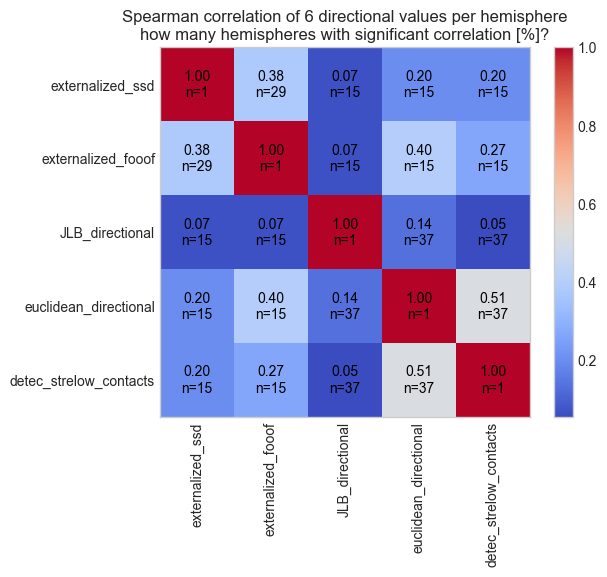

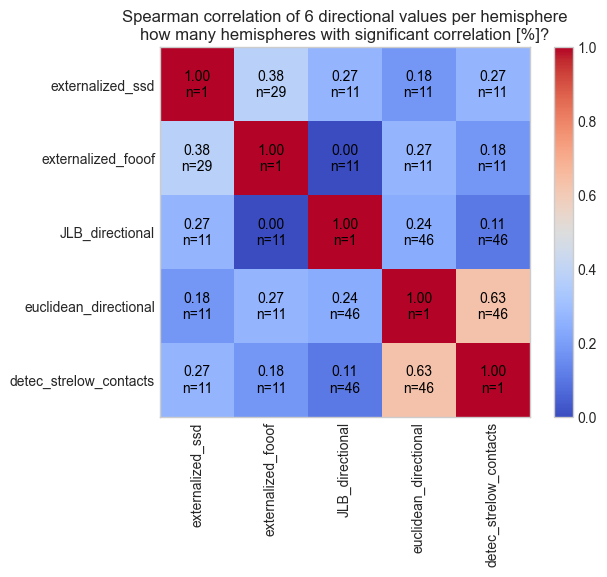

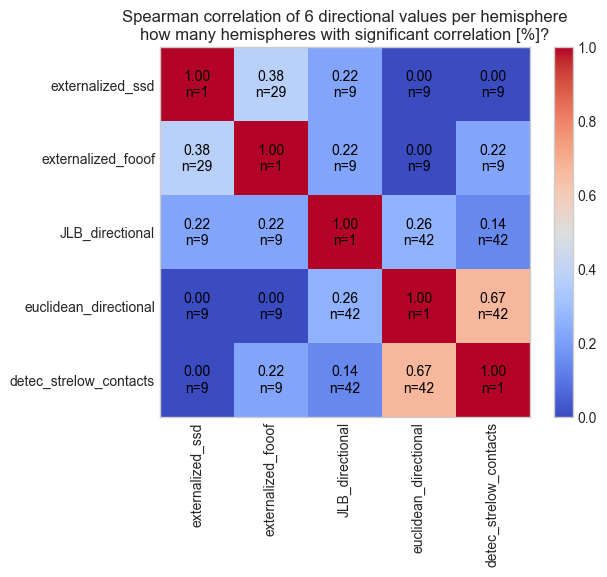

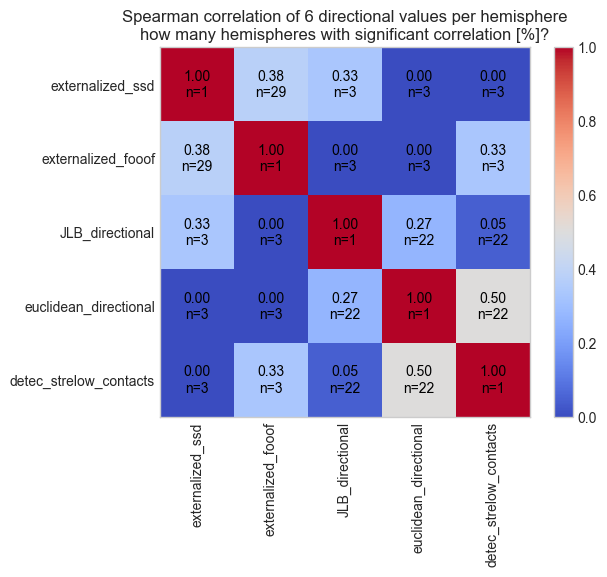

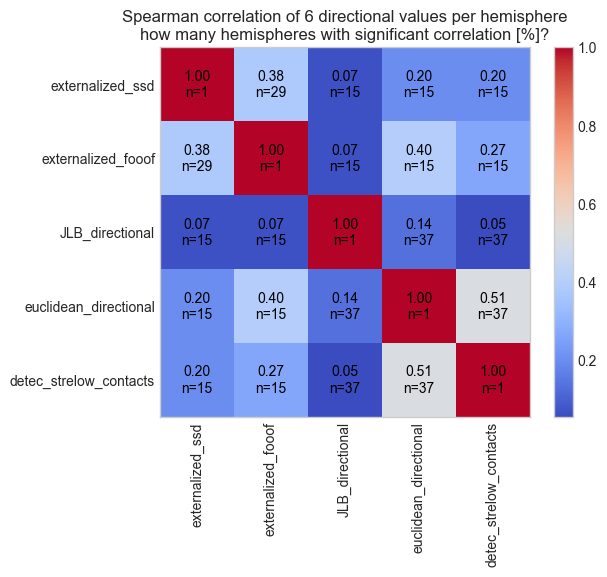

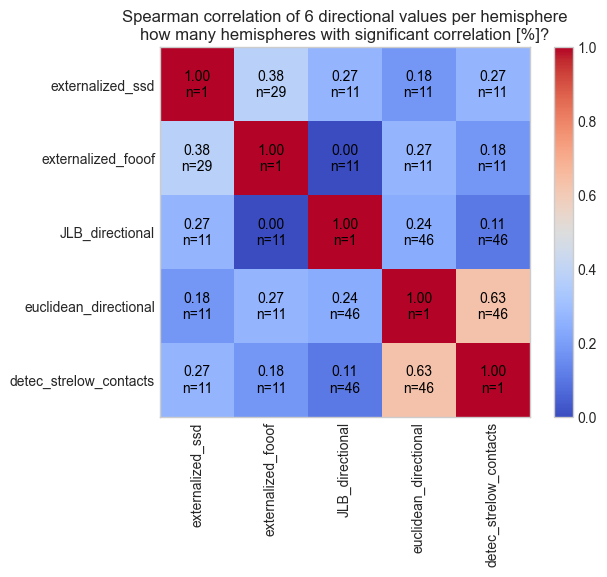

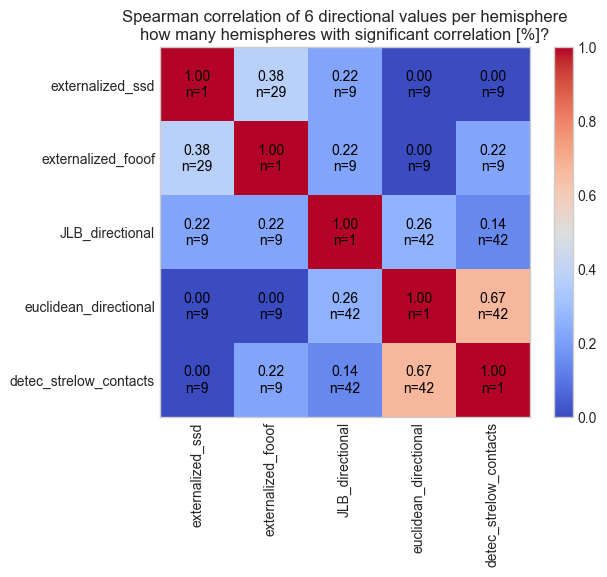

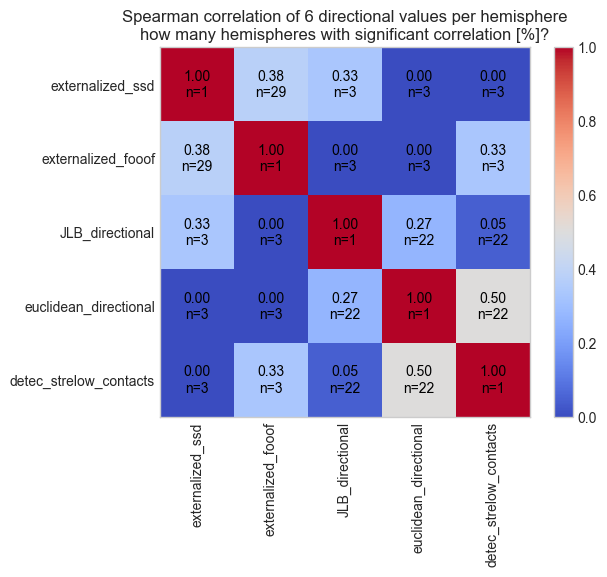

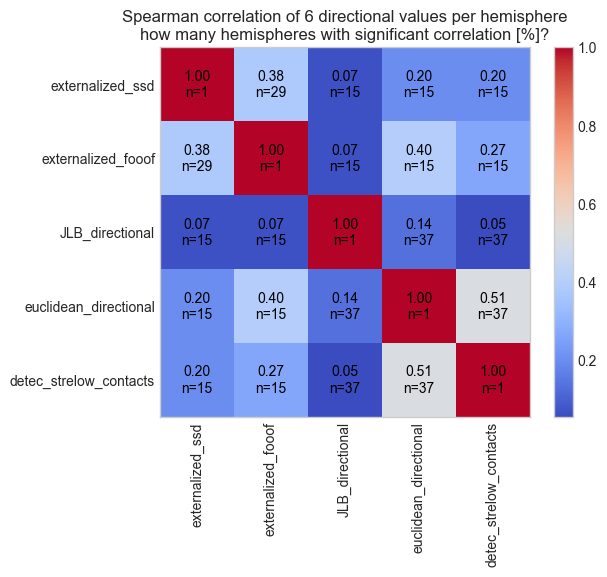

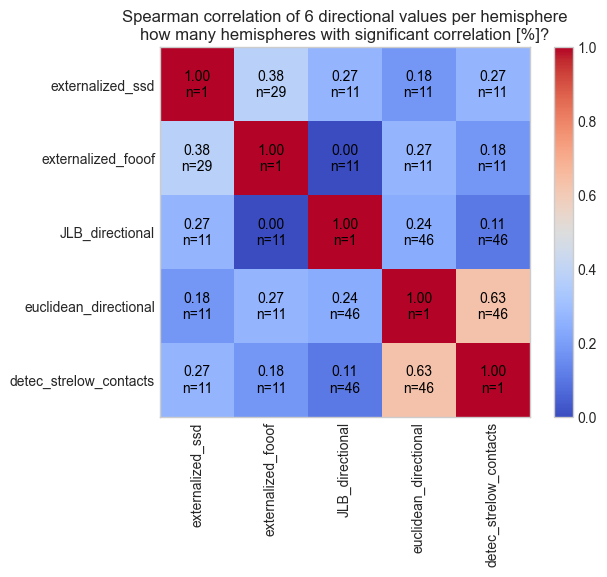

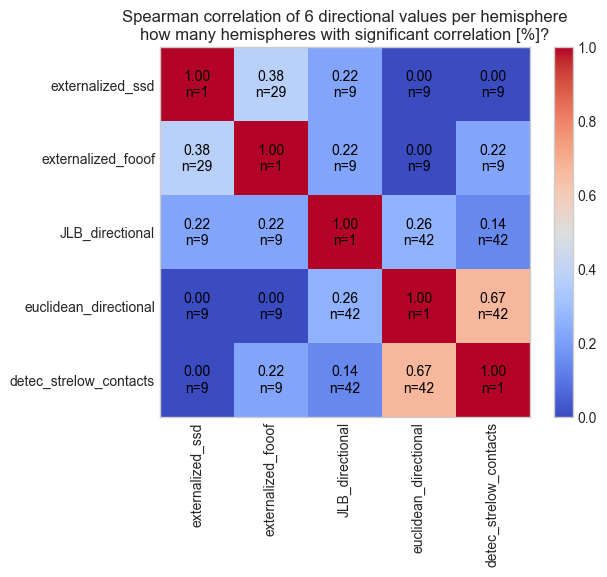

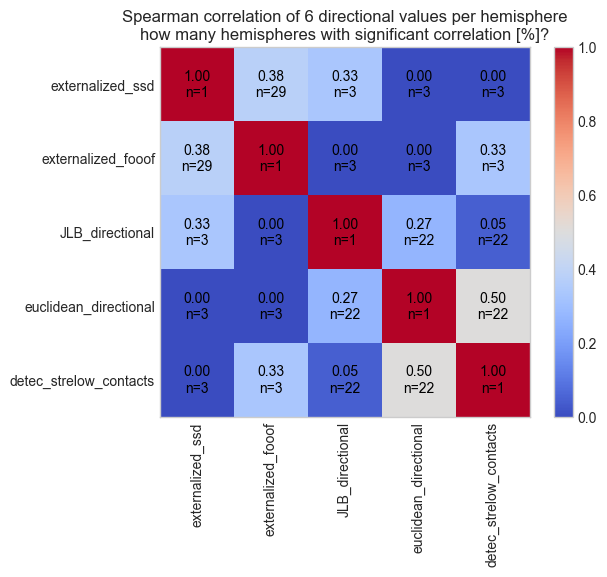

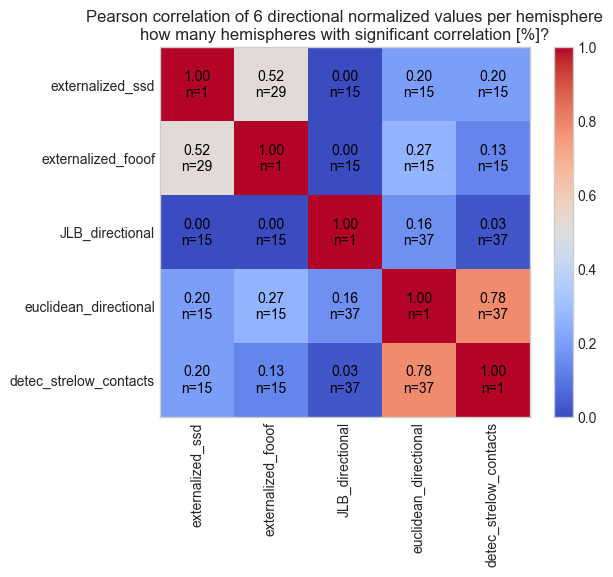

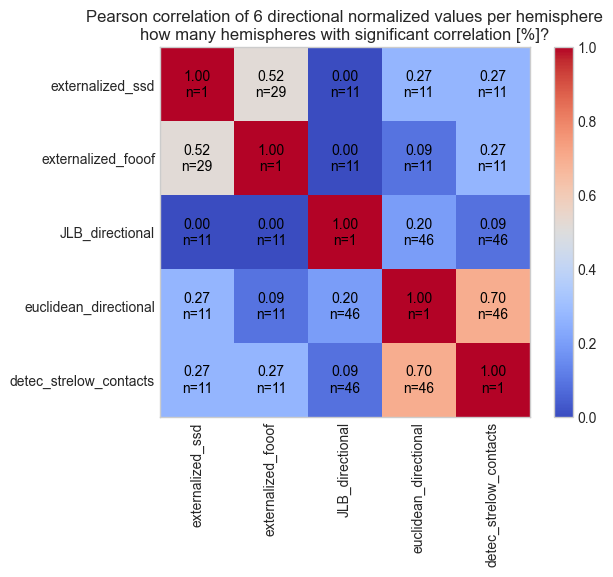

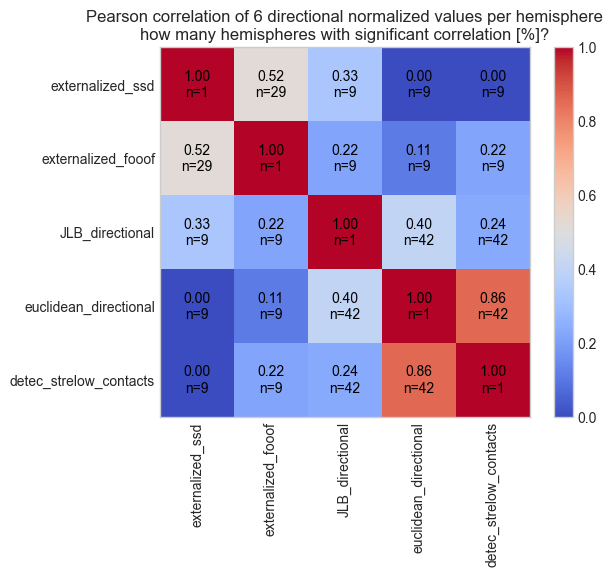

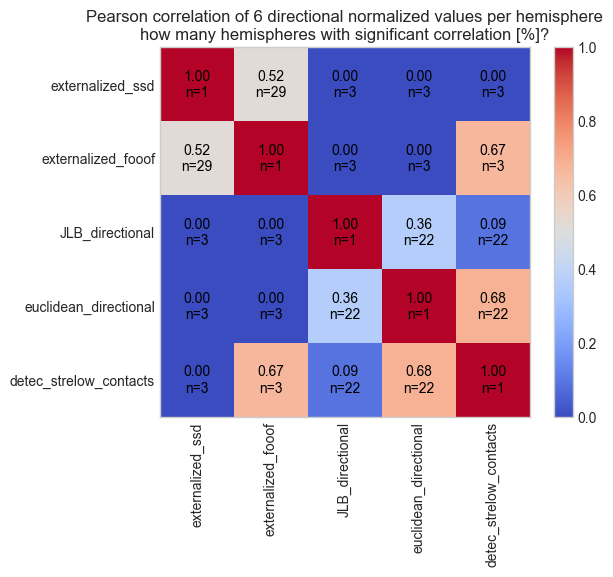

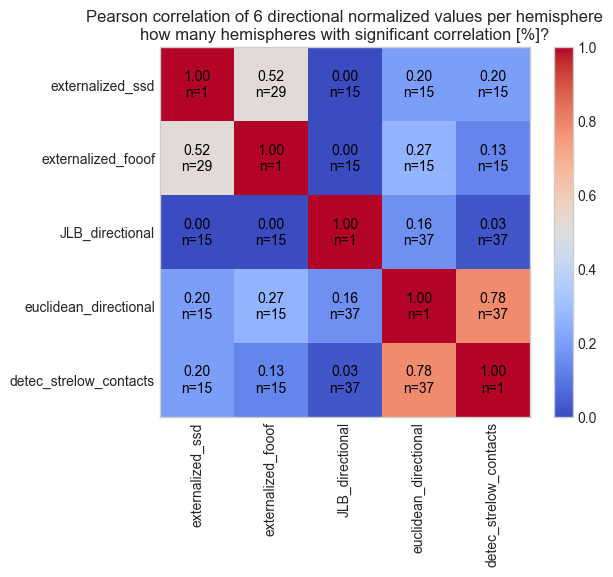

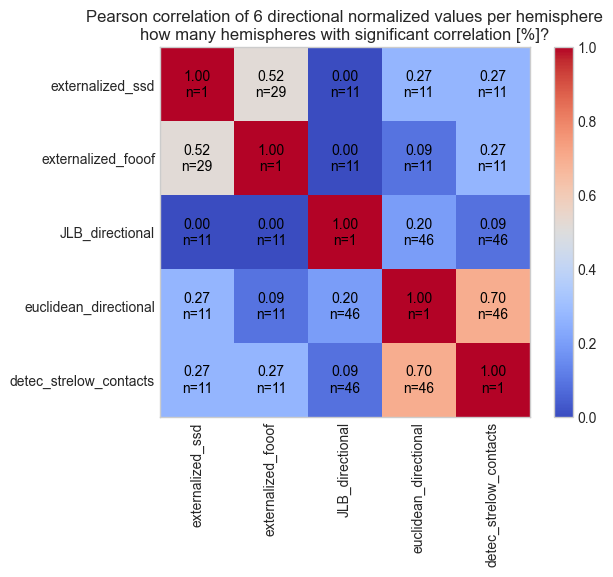

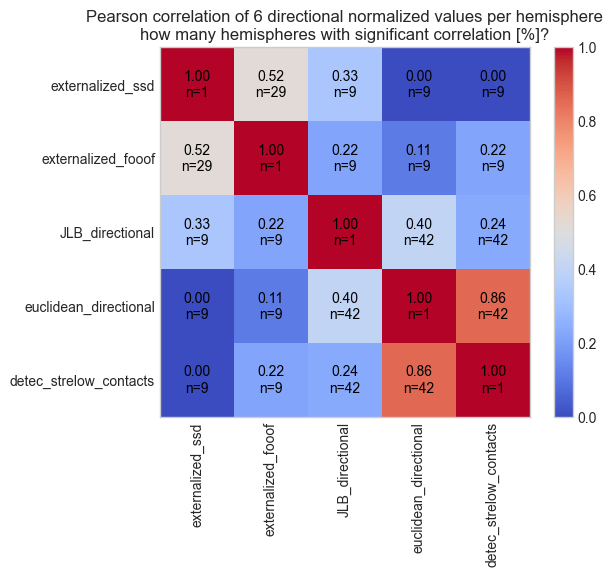

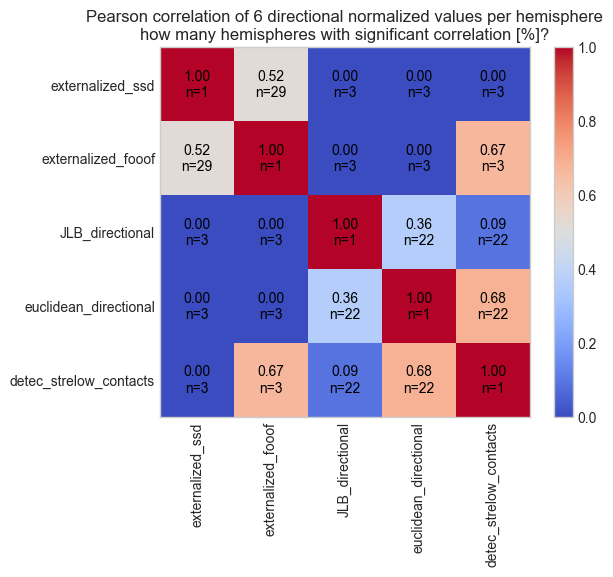

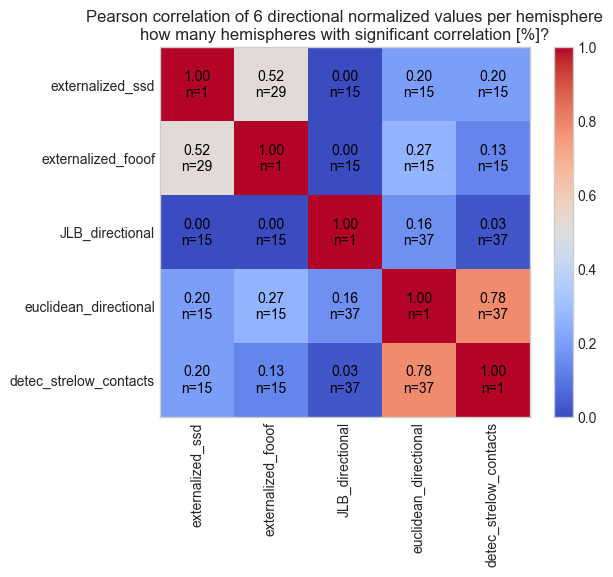

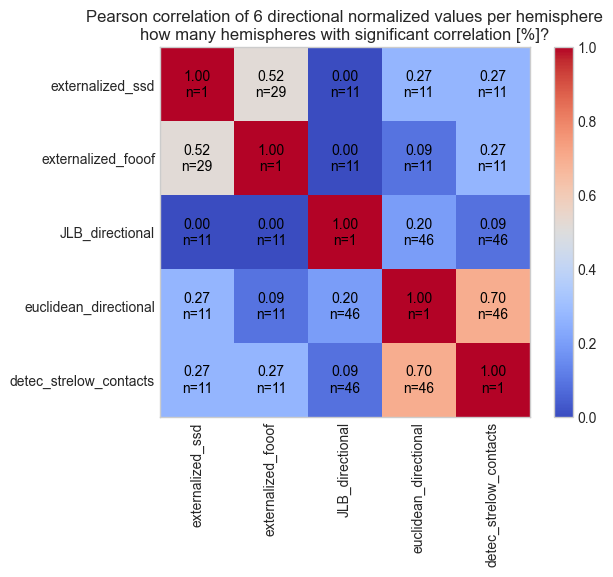

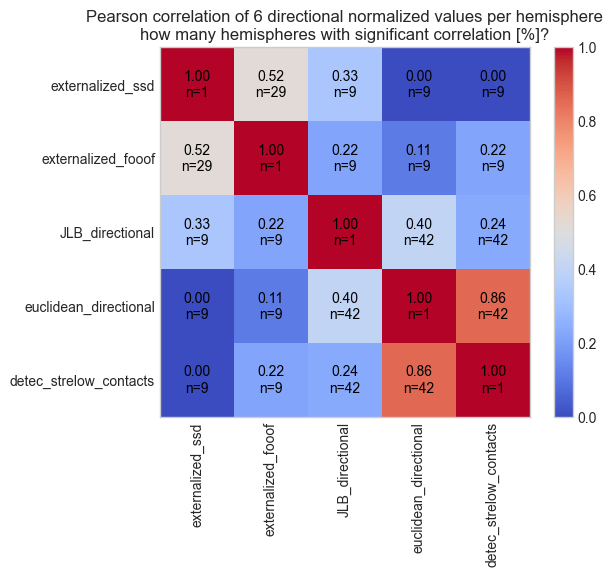

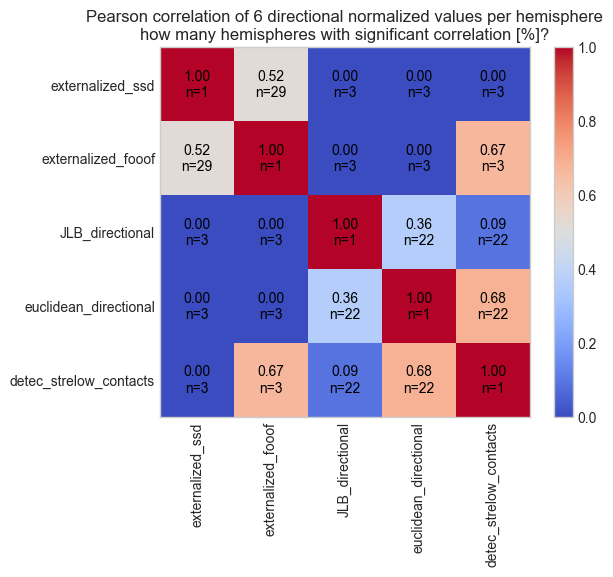

In [19]:
values_ranks = ["percentage_at_least_one_same_contact_rank_1_and_2", "percentage_both_contacts_matching"]
values_correlation = ["estimated_beta_spearman", "normalized_beta_pearson"]
clinical = ["fu3m", "fu12m", "fu18or24m"]
percept = ["postop", "fu3m", "fu12m", "fu18or24m"]

# plot the RANK heatmaps
# watchout, for DETEC only "first_level" was used
# for v in values_ranks:
#     for clin in clinical:
#         for perc in percept:
#             heatmap = monopol_comparison.heatmap_method_comparison(
#                 value_to_plot=v, clinical_session=clin, percept_session=perc, rank_or_correlation="rank", fooof_version="v2", bssu_version="percept"
#             )

for v in values_correlation:
    for clin in clinical:
        for perc in percept:
            heatmap = monopol_comparison.heatmap_method_comparison(
                value_to_plot=v, clinical_session="fu3m", percept_session=perc, rank_or_correlation="correlation", fooof_version="v2", bssu_version="percept"
            )



Figures heatmap_method_comparison_percentage_at_least_one_same_contact_rank_1_and_2_clinical_fu3m_percept_postop_rank_v2.svg and heatmap_method_comparison_percentage_at_least_one_same_contact_rank_1_and_2_clinical_fu3m_percept_postop_rank_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


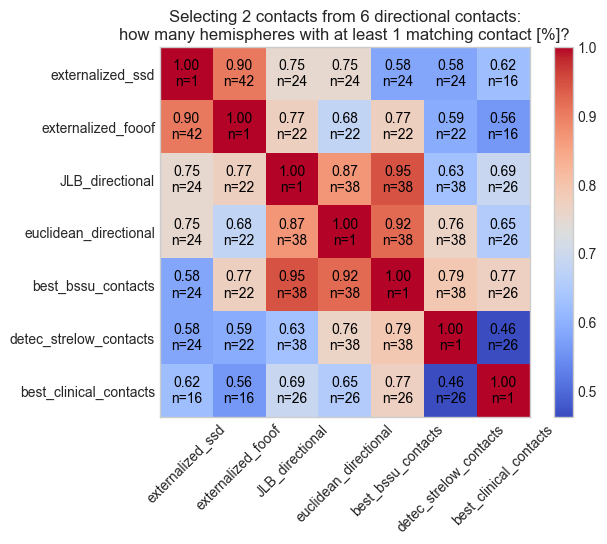

In [8]:
heatmap = monopol_comparison.heatmap_method_comparison(
    value_to_plot="percentage_at_least_one_same_contact_rank_1_and_2", clinical_session="fu3m", percept_session="postop", rank_or_correlation="rank", fooof_version="v2", bssu_version="percept"
)

In [210]:
heatmap[0]

array([[1.        , 0.9047619 , 0.75      , 0.75      , 0.58333333,
        0.625     ],
       [0.9047619 , 1.        , 0.77272727, 0.68181818, 0.77272727,
        0.5625    ],
       [0.75      , 0.77272727, 1.        , 0.81578947, 0.94736842,
        0.69230769],
       [0.75      , 0.68181818, 0.81578947, 1.        , 0.93421053,
        0.61538462],
       [0.58333333, 0.77272727, 0.94736842, 0.93421053, 1.        ,
        0.76923077],
       [0.625     , 0.5625    , 0.69230769, 0.61538462, 0.76923077,
        1.        ]])

In [259]:
heatmap[1]

{'euclidean_directional_JLB_directional': 0.18421052631578946,
 'JLB_directional_externalized_fooof': 0.13636363636363635,
 'euclidean_directional_externalized_fooof': 0.13636363636363635,
 'JLB_directional_externalized_ssd': 0.125,
 'euclidean_directional_externalized_ssd': 0.08333333333333333,
 'externalized_fooof_externalized_ssd': 0.2857142857142857}

In [5]:
heatmap[2]

{'euclidean_directional_JLB_directional': 38,
 'euclidean_directional_detec_strelow_contacts': 38,
 'JLB_directional_detec_strelow_contacts': 38,
 'detec_strelow_contacts_externalized_fooof': 22,
 'detec_strelow_contacts_externalized_ssd': 24,
 'JLB_directional_externalized_fooof': 22,
 'JLB_directional_externalized_ssd': 24,
 'euclidean_directional_externalized_fooof': 22,
 'euclidean_directional_externalized_ssd': 24,
 'externalized_fooof_externalized_ssd': 42}

## Externalized BSSU methods vs. Externalized Original

Write the group comparison dictionary

In [12]:

clinical = ["fu3m", "fu12m", "fu18or24m"]

########### compare ranks: group dataframe 
# for clin in clinical:
# comparison_all_methods = monopol_comparison.group_rank_comparison_externalized_percept_clinical(
#     clinical_session="fu12m", percept_session="postop", fooof_version="v2", bssu_version="externalized"
# )


#for clin in clinical:
comparison_all_methods = monopol_comparison.group_correlation_comparison_externalized_percept_clinical(
    percept_session="postop", fooof_version="v2", bssu_version="externalized"
)


/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


file:  fooof_monopol_beta_correlations_per_stn_euclidean_directional_externalized_bssu_euclidean_directional_externalized_bssu_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
Sub-067_Left has NaN values in the estimated beta average.
Sub-069_Right has NaN values in the estimated beta average.
Sub-079_Left has NaN values in the estimated beta average.
file:  fooof_monopol_beta_correlations_per_stn_euclidean_directional_externalized_bssu_JLB_directional_externalized_bssu_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
Strelow method: all directional contact values
file:  fooof_monopol_beta_correlations_per_stn_euclidean_directional_externalized_bssu_detec_strelow_contacts_externalized_bssu_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
Sub-067_Left has NaN values in the estimated beta average.
Sub-069_Right

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


file:  fooof_monopol_beta_correlations_per_stn_detec_strelow_contacts_externalized_bssu_detec_strelow_contacts_externalized_bssu_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_per_stn_euclidean_directional_externalized_bssu_externalized_fooof_bipolar_to_lowermost_v2_postop_externalized_bssu.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_per_stn_euclidean_directional_externalized_bssu_externalized_ssd_bipolar_to_lowermost_v2_postop_externalized_bssu.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
Sub-067_Left has NaN values in the estimated beta average.
Sub-069_Right has NaN values in the estimated beta average.
Sub-079_Left has NaN values in the estimated beta average.
file:  fooof_monopol_beta_correlations_per_stn_JLB_directional_e

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Sub-067_Left has NaN values in the estimated beta average.
Sub-069_Right has NaN values in the estimated beta average.
Sub-079_Left has NaN values in the estimated beta average.
file:  fooof_monopol_beta_correlations_per_stn_JLB_directional_externalized_bssu_externalized_ssd_bipolar_to_lowermost_v2_postop_externalized_bssu.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_per_stn_detec_strelow_contacts_externalized_bssu_externalized_fooof_bipolar_to_lowermost_v2_postop_externalized_bssu.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_per_stn_detec_strelow_contacts_externalized_bssu_externalized_ssd_bipolar_to_lowermost_v2_postop_externalized_bssu.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_per_stn_

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


file:  fooof_monopol_beta_correlations_per_stn_externalized_fooof_externalized_ssd_bipolar_to_lowermost_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_per_stn_externalized_ssd_externalized_fooof_bipolar_to_lowermost_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  fooof_monopol_beta_correlations_per_stn_externalized_ssd_externalized_ssd_bipolar_to_lowermost_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
correlation_group_comparison_all_externalized_percept_postop_externalized_bssu_v2.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
file:  correlation_group_comparison_all_externalized_percept_postop_externalized_bssu_v2.xlsx 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_powe

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


LOAD THE COMPARISON

In [6]:
load_data = mono_comp_helpers.load_comparison_result_DF(
    method_comparison= "euclidean_directional_externalized_bssu_externalized_fooof", comparison_file="rank", clinical_session="fu12m", percept_session="postop", fooof_version="v2", bssu_version="externalized"
)

In [7]:
load_data

,method_1,method_2,session,sample_size,both_contacts_matching,percentage_both_contacts_matching,at_least_1_contact_same,percentage_at_least_one_same_contact_rank_1_and_2,same_rank_1,percentage_same_rank_1,session_clinical,rank_or_rel,method_comparison
16,euclidean_directional_externalized_bssu,externalized_fooof,postop,33,9,0.272727,24,0.727273,21.0,0.636364,NaN,NaN,euclidean_directional_externalized_bssu_extern...


In [9]:
heatmap = mono_comp_helpers.get_comparison_matrix_for_heatmap_from_DF(
    value_to_plot="percentage_at_least_one_same_contact_rank_1_and_2",
    clinical_session="fu12m",
    percept_session="postop",
    rank_or_correlation="rank",
    fooof_version="v2",
    bssu_version="externalized",
)

In [12]:
heatmap["comparison_matrix"]

array([[1.        , 0.93939394, 0.64285714, 0.81818182, 0.90909091,
        0.73333333, 0.58333333],
       [0.93939394, 1.        , 0.60714286, 0.72727273, 0.90909091,
        0.83333333, 0.83333333],
       [0.64285714, 0.60714286, 1.        , 0.57142857, 0.78571429,
        0.46153846, 0.75      ],
       [0.81818182, 0.72727273, 0.57142857, 1.        , 1.        ,
        0.76666667, 0.75      ],
       [0.90909091, 0.90909091, 0.78571429, 1.        , 1.        ,
        0.93333333, 0.83333333],
       [0.73333333, 0.83333333, 0.46153846, 0.76666667, 0.93333333,
        1.        , 0.63636364],
       [0.58333333, 0.83333333, 0.75      , 0.75      , 0.83333333,
        0.63636364, 1.        ]])

In [14]:
heatmap["sample_size"]

{'euclidean_directional_externalized_bssu_JLB_directional_externalized_bssu': 28,
 'euclidean_directional_externalized_bssu_best_bssu_contacts_externalized_bssu': 33,
 'euclidean_directional_externalized_bssu_detec_strelow_contacts_externalized_bssu': 30,
 'JLB_directional_externalized_bssu_best_bssu_contacts_externalized_bssu': 28,
 'JLB_directional_externalized_bssu_detec_strelow_contacts_externalized_bssu': 26,
 'detec_strelow_contacts_externalized_bssu_best_bssu_contacts_externalized_bssu': 30,
 'externalized_fooof_detec_strelow_contacts_externalized_bssu': 30,
 'externalized_ssd_detec_strelow_contacts_externalized_bssu': 30,
 'JLB_directional_externalized_bssu_externalized_fooof': 28,
 'JLB_directional_externalized_bssu_externalized_ssd': 28,
 'euclidean_directional_externalized_bssu_externalized_fooof': 33,
 'euclidean_directional_externalized_bssu_externalized_ssd': 33,
 'externalized_fooof_best_bssu_contacts_externalized_bssu': 33,
 'externalized_ssd_best_bssu_contacts_external

PLOT HEATMAP

Figures heatmap_method_comparison_estimated_beta_spearman_clinical_fu12m_percept_postop_externalized_bssu_correlation_v2.svg and heatmap_method_comparison_estimated_beta_spearman_clinical_fu12m_percept_postop_externalized_bssu_correlation_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.
Figures heatmap_method_comparison_normalized_beta_pearson_clinical_fu12m_percept_postop_externalized_bssu_correlation_v2.svg and heatmap_method_comparison_normalized_beta_pearson_clinical_fu12m_percept_postop_externalized_bssu_correlation_v2.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


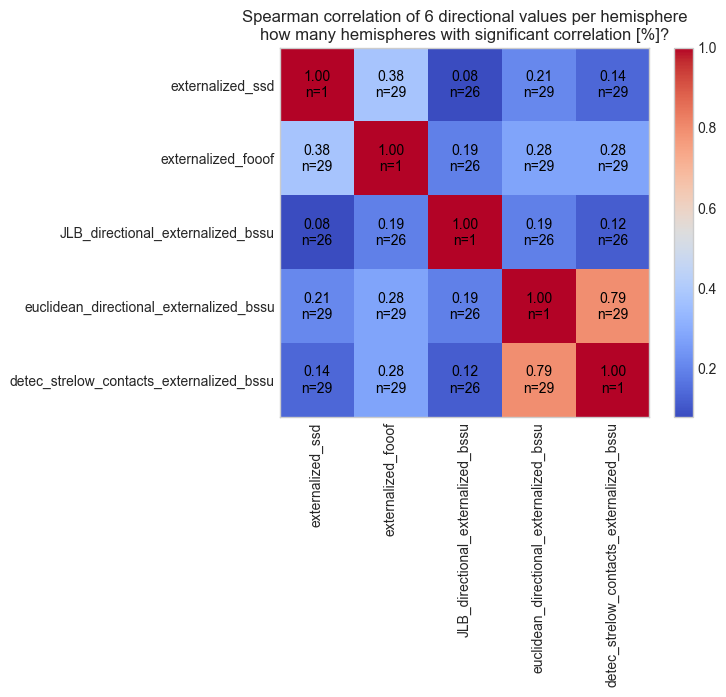

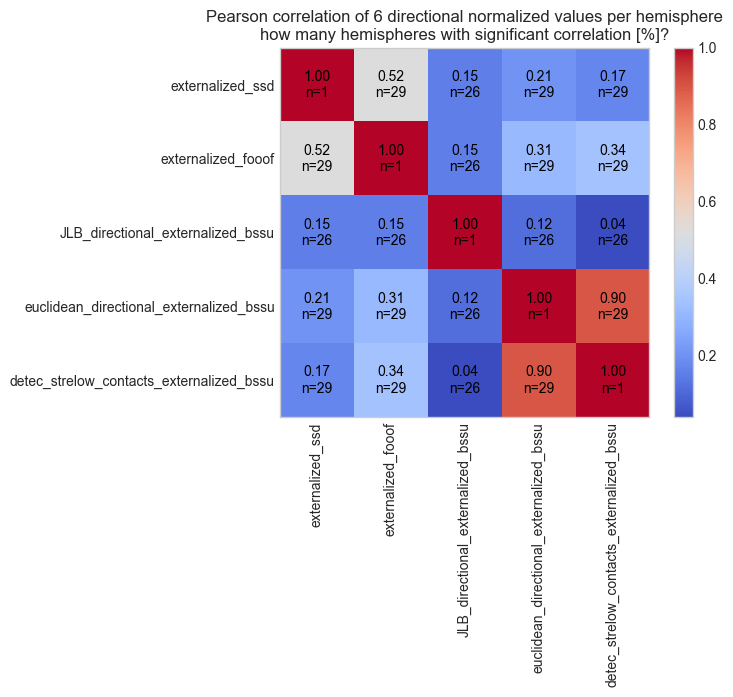

In [13]:
values_ranks = ["percentage_at_least_one_same_contact_rank_1_and_2", "percentage_both_contacts_matching"]
values_correlation = ["estimated_beta_spearman", "normalized_beta_pearson"]
clinical = ["fu3m", "fu12m", "fu18or24m"]
percept = ["postop", "fu3m", "fu12m", "fu18or24m"]

# plot the RANK heatmaps
# watchout, for DETEC only "first_level" was used
for v in values_correlation:
    heatmap = monopol_comparison.heatmap_method_comparison(
        value_to_plot=v, clinical_session="fu12m", percept_session="postop", rank_or_correlation="correlation", fooof_version="v2", bssu_version="externalized"
    )

